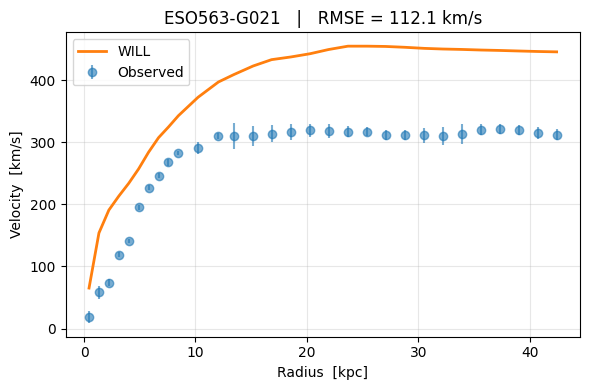

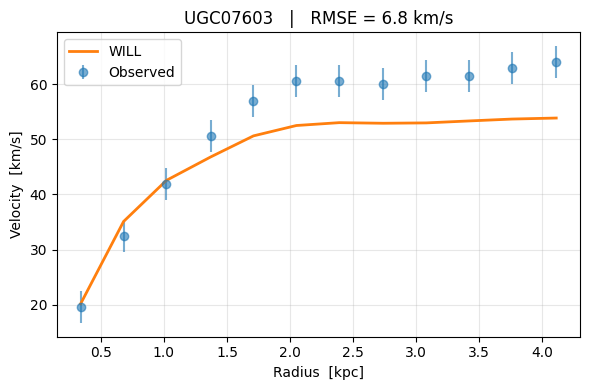

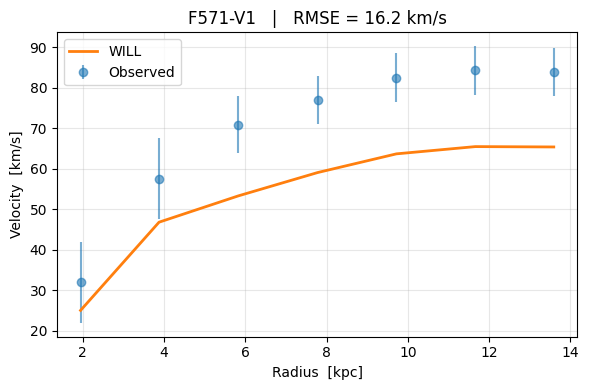

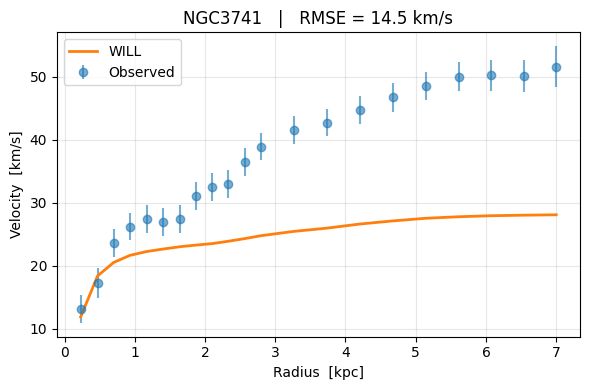

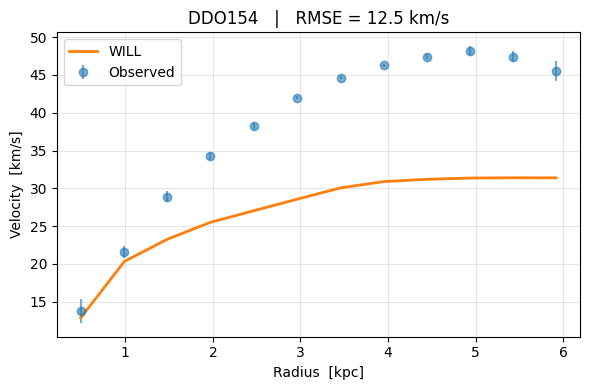

,RMSE_km/s
Galaxy,
UGC07603,6.843744
DDO154,12.475874
NGC3741,14.465591
F571-V1,16.208084
ESO563-G021,112.148014


In [ ]:
# ================== WILL Galaxy-by-Galaxy Diagnostic ==================
# Put this cell in a fresh Colab notebook  ─ it needs only numpy/pandas/plt/scipy
# ======================================================================

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

# --------------------- 1. Configuration --------------------------------
DATA_DIR  = '/content/DATA'      # <-- verify this path in your Colab runtime
TARGETS   = [                    # <-- list the handful you want to study
    'ESO563-G021', 'UGC07603', 'F571-V1', 'NGC3741', 'DDO154'
]
N_ITER    = 5                    # iterative depth (5 → <1 % change)

PLOT_EACH = True                 # set False if you only need the numbers
# -----------------------------------------------------------------------

def will_curve(df: pd.DataFrame, n_iter=N_ITER):
    """
    Compute WILL prediction after n_iter geometric 'onion' updates.
    Assumes df contains columns r_kpc, Vgas, Vdsk, Vbul.
    """
    vb_sq        = df['Vgas']**2 + df['Vdsk']**2 + df['Vbul']**2
    v_sq_current = vb_sq.copy()
    non_zero_r   = df['r_kpc'] > 0

    for _ in range(n_iter):
        integ = cumulative_trapezoid(v_sq_current, df['r_kpc'], initial=0.0)
        geom  = np.zeros_like(df['r_kpc'])
        geom[non_zero_r] = integ[non_zero_r] / df.loc[non_zero_r, 'r_kpc']
        v_sq_current = vb_sq + geom

    return np.sqrt(np.maximum(0, v_sq_current))

def analyze_one(filepath: str):
    cols = ['r_kpc','Vobs','Verr','Vgas','Vbul','Vdsk']
    try:
        df = pd.read_csv(filepath, sep=r'\s+', comment='#', header=None,
                         names=cols, usecols=range(6))
    except (FileNotFoundError, pd.errors.EmptyDataError, ValueError):
        return None

    if len(df) < 5:                       # discard tiny / empty files
        return None
    df = df.fillna(0).sort_values('r_kpc').reset_index(drop=True)

    df['Vwill'] = will_curve(df)
    valid       = df[df['Vobs'] > 0]
    if valid.empty:
        return None
    rmse = np.sqrt(np.mean((valid['Vobs'] - valid['Vwill'])**2))
    return df, rmse

# -------------------- 2. Main loop -------------------------------------
results = []
for name in TARGETS:
    path = os.path.join(DATA_DIR, f'{name}_rotmod.dat')
    out  = analyze_one(path)
    if out is None:
        print(f'⚠️  Skipped {name} (missing or bad file)')
        continue
    df, rmse = out
    results.append({'Galaxy': name, 'RMSE_km/s': rmse})

    if PLOT_EACH:
        plt.figure(figsize=(6,4))
        plt.errorbar(df['r_kpc'], df['Vobs'], yerr=df['Verr'], fmt='o',
                     label='Observed', alpha=0.6)
        plt.plot(df['r_kpc'], df['Vwill'], '-', lw=2, label='WILL')
        plt.title(f'{name}   |   RMSE = {rmse:0.1f} km/s')
        plt.xlabel('Radius  [kpc]')
        plt.ylabel('Velocity  [km/s]')
        plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
        plt.show()

# -------------------- 3. Summary table ---------------------------------
pd.DataFrame(results).set_index('Galaxy').sort_values('RMSE_km/s')

✅  Suitable galaxies: 93 / 175  (53.1 %)

=====  WILL performance on clean sample  =====
Galaxies analysed   : 93
Median RMSE [km/s]  : 28.52
90th-percentile RMSE: 248.12



,RMSE_km_s
Galaxy,
UGC05414,1.631349
UGC04499,2.246902
UGC08490,2.400484
F583-4,2.711779
UGC06917,3.371502
DDO161,4.786654
UGC05721,4.891677
UGC07603,6.843744
NGC0024,7.053957


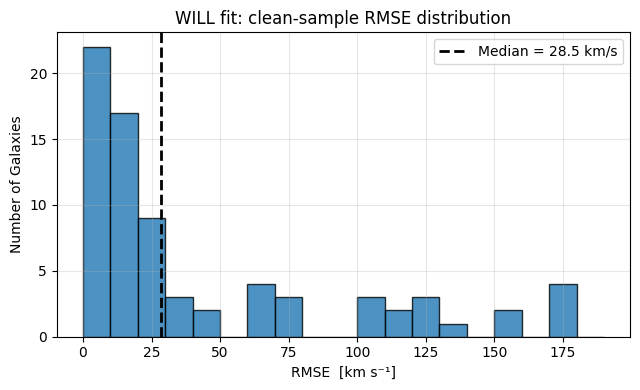

In [ ]:
# ====================  WILL clean-sample pipeline  ====================
#   Needs only: table1.dat  table2.dat  in  /content/DATA
# =====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR   = '/content/DATA'
META_FILE  = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'
N_ITER     = 5              # depth of onion iterations
PLOT_HIST  = True           # switch off if you don’t want the histogram

# ---------------------------------------------------------------------
# 1) LOAD METADATA  (fixed-width)  – robust to blanks / NaNs
# ---------------------------------------------------------------------
meta_colspecs = [
    (0,11),   # Galaxy
    (12,14),  # Morphology / Hubble type
    (30,34),  # Inclination [deg]
    (112,115) # Quality flag (1 = best)
]
meta_names = ['Galaxy','Morphology','Incl_deg','Qual']

meta = pd.read_fwf(META_FILE, colspecs=meta_colspecs, names=meta_names)
meta['Morphology'] = (
    meta['Morphology'].fillna('').astype(str).str.strip().str.lower()
)
meta['Qual']      = pd.to_numeric(meta['Qual'], errors='coerce')
meta['Incl_deg']  = pd.to_numeric(meta['Incl_deg'], errors='coerce')

# ---------------------------------------------------------------------
# 2) FLAG SUITABLE GALAXIES
# ---------------------------------------------------------------------
EXCLUDE_KEYS = ['sb', 'sab', 'ib', 'bar', 'pec', 'irr']  # barred / irregular
MIN_INCL = 30                                            # deg

def unsuitable(row):
    bad_morph = any(k in row['Morphology'] for k in EXCLUDE_KEYS)
    low_incl  = (pd.isna(row['Incl_deg']) or row['Incl_deg'] < MIN_INCL)
    bad_qual  = (pd.isna(row['Qual'])      or row['Qual'] != 1)
    return bad_morph or low_incl or bad_qual

meta['unsuitable'] = meta.apply(unsuitable, axis=1)
good_galaxies = set(meta.loc[~meta['unsuitable'], 'Galaxy'])
print(f'✅  Suitable galaxies: {len(good_galaxies)} / {len(meta)}'
      f'  ({100*len(good_galaxies)/len(meta):.1f} %)')

# ---------------------------------------------------------------------
# 3) LOAD ALL ROTATION-CURVE POINTS
# ---------------------------------------------------------------------
curve_colspecs = [
    (0,11),   # Galaxy
    (19,25),  # r_kpc
    (26,32),  # Vobs
    (39,45),  # Vgas
    (46,52),  # Vdisk
    (53,59),  # Vbul
]
curve_names = ['Galaxy','r_kpc','Vobs','Vgas','Vdisk','Vbul']

curves = pd.read_fwf(CURVE_FILE, colspecs=curve_colspecs, names=curve_names)
curves = curves[curves['Galaxy'].isin(good_galaxies)].copy()
curves[['r_kpc','Vobs','Vgas','Vdisk','Vbul']] = curves[
    ['r_kpc','Vobs','Vgas','Vdisk','Vbul']].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r_kpc','Vobs'], inplace=True)

# ---------------------------------------------------------------------
# 4) WILL “ONION” SOLVER
# ---------------------------------------------------------------------
def will_velocity(df, n_iter=N_ITER):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    nz    = df['r_kpc'] > 0
    for _ in range(n_iter):
        integ = cumulative_trapezoid(v_sq, df['r_kpc'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = integ[nz] / df.loc[nz, 'r_kpc']
        v_sq  = vb_sq + geom
    return np.sqrt(np.clip(v_sq, 0, None))

# ---------------------------------------------------------------------
# 5) PER-GALAXY LOOP & RMSE
# ---------------------------------------------------------------------
records = []
for gal, gdf in curves.groupby('Galaxy'):
    gdf = gdf.sort_values('r_kpc')
    if len(gdf) < 5:
        continue
    gdf['Vwill'] = will_velocity(gdf)
    valid = gdf[gdf['Vobs'] > 0]
    rmse  = np.sqrt(np.mean((valid['Vobs'] - valid['Vwill'])**2))
    records.append({'Galaxy': gal, 'RMSE_km_s': rmse})

clean_df = (pd.DataFrame(records)
            .set_index('Galaxy')
            .sort_values('RMSE_km_s'))

# ---------------------------------------------------------------------
# 6) REPORT
# ---------------------------------------------------------------------
print('\n=====  WILL performance on clean sample  =====')
print(f'Galaxies analysed   : {len(clean_df)}')
print(f'Median RMSE [km/s]  : {clean_df.RMSE_km_s.median():.2f}')
print(f'90th-percentile RMSE: {clean_df.RMSE_km_s.quantile(0.9):.2f}\n')
display(clean_df.head(15))   # show best 15 fits

# ---------------------------------------------------------------------
# 7) OPTIONAL HISTOGRAM
# ---------------------------------------------------------------------
if PLOT_HIST:
    plt.figure(figsize=(6.5,4))
    plt.hist(clean_df.RMSE_km_s, bins=np.arange(0,200,10),
             edgecolor='k', alpha=0.8)
    plt.axvline(clean_df.RMSE_km_s.median(), ls='--', lw=2, c='k',
                label=f'Median = {clean_df.RMSE_km_s.median():.1f} km/s')
    plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
    plt.title('WILL fit: clean-sample RMSE distribution')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

✅  Suitable galaxies: 153 / 175 (87.4 %)

=====  WILL performance : relaxed clean sample  =====
Galaxies analysed   : 149
Median RMSE  [km/s] : 21.38
90th-percentile RMSE: 235.07



,RMSE_km_s
Galaxy,
UGC04483,1.386352
UGC07866,1.545150
UGC05414,1.631349
UGC07559,1.731612
UGC04499,2.246902
UGC08490,2.400484
F583-4,2.711779
KK98-251,3.097666
UGC06917,3.371502


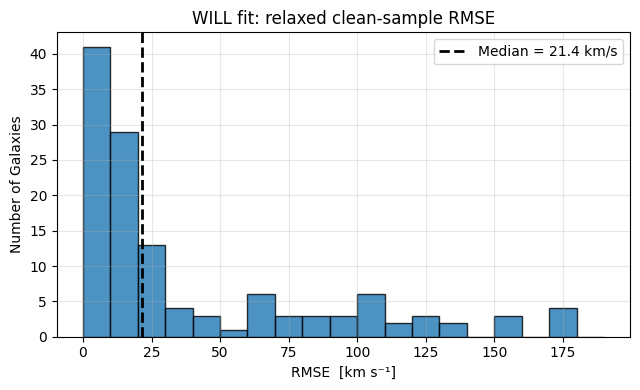

In [ ]:
# =================  WILL pipeline : relaxed clean sample  ==============
#  works with  table1.dat  &  table2.dat  in  /content/DATA
# ======================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR  = '/content/DATA'
META_FILE = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'
N_ITER    = 5
PLOT_HIST = True

# ---------------- 1. load metadata (robust) ---------------------------
meta_cols  = [(0,11),(12,14),(30,34),(112,115)]
meta_names = ['Galaxy','Morph','Incl','Qual']
meta = pd.read_fwf(META_FILE, colspecs=meta_cols, names=meta_names)

meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
meta['Incl']  = pd.to_numeric(meta['Incl'],  errors='coerce')
meta['Qual']  = pd.to_numeric(meta['Qual'],  errors='coerce')

# --------------- 2. define relaxed suitability mask -------------------
EXCLUDE_KEYS = ['im', 'irr', 'pec', 'ib', 'int']   # obviously messy systems
MIN_INCL = 30                                      # degrees
MAX_QUAL = 2                                       # accept Q = 1 or 2

def unsuitable(row):
    bad_morph = any(k in row['Morph'] for k in EXCLUDE_KEYS)
    low_incl  = (pd.isna(row['Incl']) or row['Incl'] < MIN_INCL)
    bad_qual  = (pd.isna(row['Qual']) or row['Qual'] > MAX_QUAL)
    return bad_morph or low_incl or bad_qual

meta['unsuitable'] = meta.apply(unsuitable, axis=1)
good_set = set(meta.loc[~meta['unsuitable'], 'Galaxy'])
print(f'✅  Suitable galaxies: {len(good_set)} / {len(meta)} '
      f'({100*len(good_set)/len(meta):.1f} %)')

# --------------- 3. load all curve points -----------------------------
curve_cols  = [(0,11),(19,25),(26,32),(39,45),(46,52),(53,59)]
curve_names = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
curves = pd.read_fwf(CURVE_FILE, colspecs=curve_cols, names=curve_names)
curves = curves[curves['Galaxy'].isin(good_set)].copy()
num_cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# --------------- 4. WILL onion solver ---------------------------------
def will_v(df, n=N_ITER):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    nz    = df['r'] > 0
    for _ in range(n):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = integ[nz] / df.loc[nz, 'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq, 0, None))

# --------------- 5. per-galaxy RMSE -----------------------------------
records = []
for gal, gdf in curves.groupby('Galaxy'):
    gdf = gdf.sort_values('r')
    if len(gdf) < 5: continue
    gdf['Vwill'] = will_v(gdf)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - gdf['Vwill'])**2))
    records.append({'Galaxy': gal, 'RMSE_km_s': rmse})

clean = (pd.DataFrame(records)
         .set_index('Galaxy')
         .sort_values('RMSE_km_s'))

# --------------- 6. report -------------------------------------------
print('\n=====  WILL performance : relaxed clean sample  =====')
print(f'Galaxies analysed   : {len(clean)}')
print(f'Median RMSE  [km/s] : {clean.RMSE_km_s.median():.2f}')
print(f'90th-percentile RMSE: {clean.RMSE_km_s.quantile(0.9):.2f}\n')
display(clean.head(15))

# --------------- 7. optional histogram -------------------------------
if PLOT_HIST:
    plt.figure(figsize=(6.5,4))
    plt.hist(clean.RMSE_km_s, bins=np.arange(0,200,10),
             edgecolor='k', alpha=0.8)
    plt.axvline(clean.RMSE_km_s.median(), ls='--', lw=2, c='k',
                label=f'Median = {clean.RMSE_km_s.median():.1f} km/s')
    plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
    plt.title('WILL fit: relaxed clean-sample RMSE')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


Top-10 galaxies by RMSE:


,RMSE_km_s
Galaxy,
UGC09133,346.572532
UGC06787,325.700443
UGC02953,305.592205
NGC0891,304.194396
UGC05253,291.961324
UGC03546,290.898329
NGC5005,280.487601
NGC7331,276.931209
NGC5055,264.650582


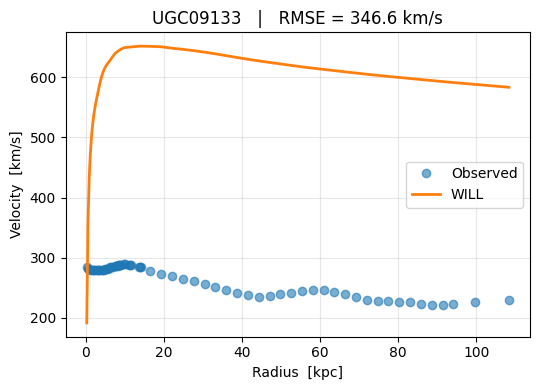

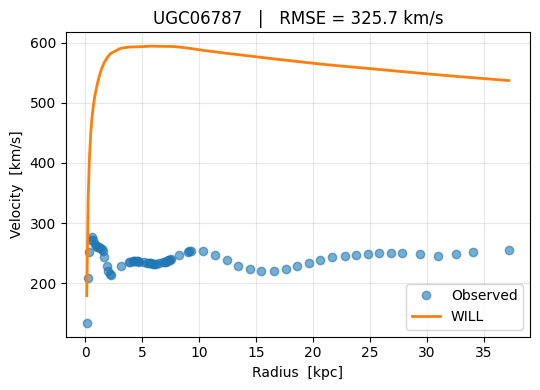

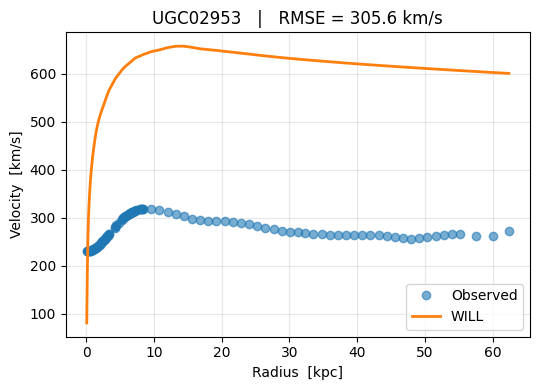

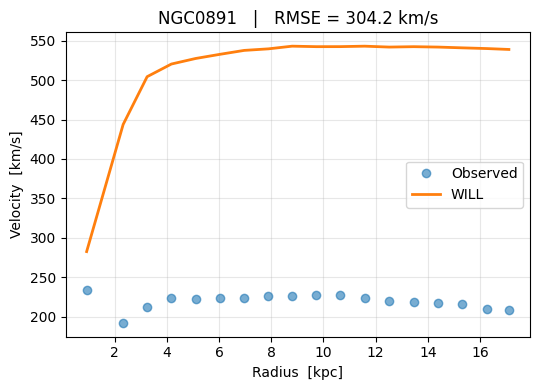

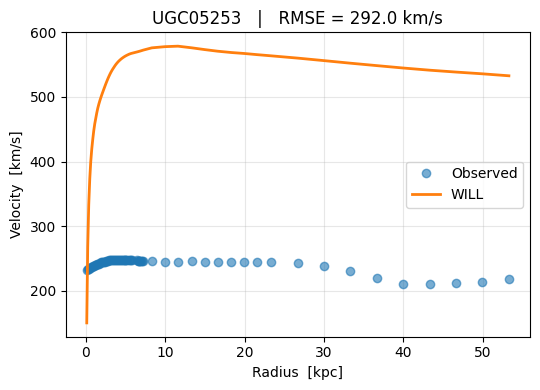

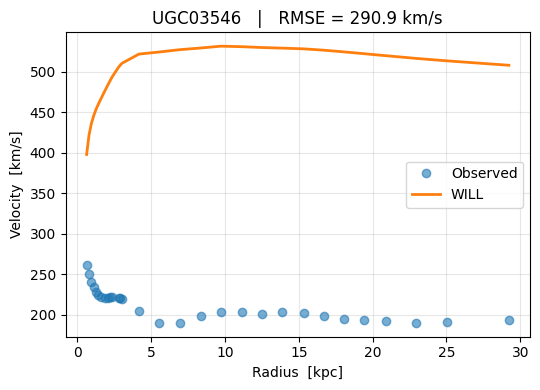

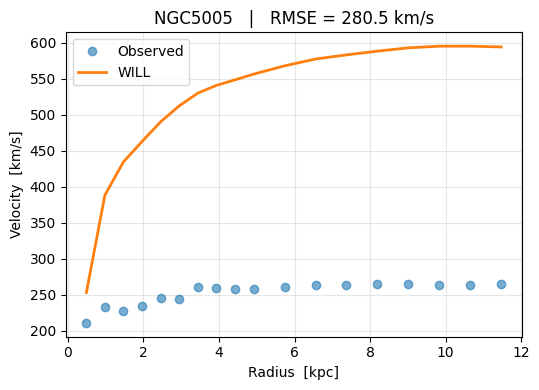

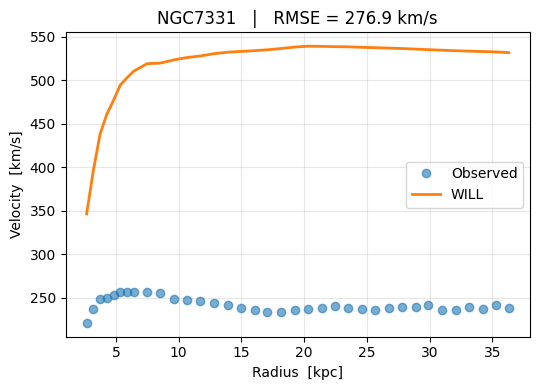

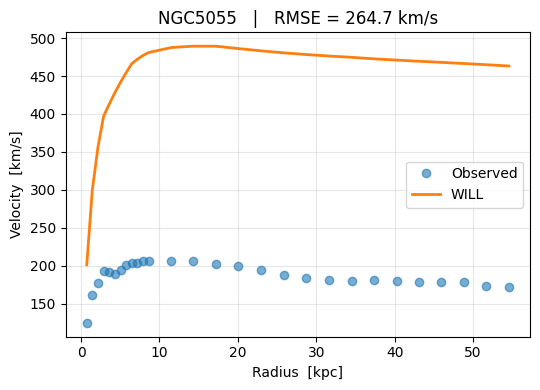

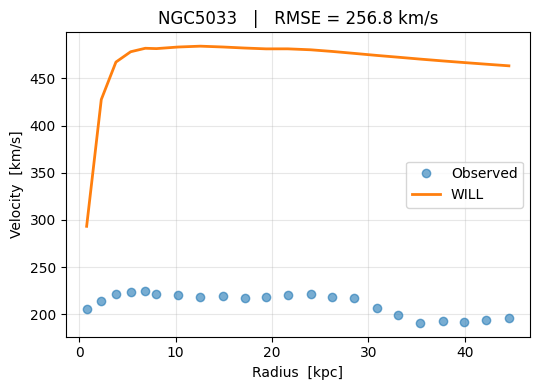

from matplotlib import pyplot as plt
_df_5['RMSE_km_s'].plot(kind='hist', bins=20, title='RMSE_km_s')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['RMSE_km_s'].plot(kind='line', figsize=(8, 4), title='RMSE_km_s')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# =================  Diagnose worst residuals  =========================
#  (Run after the relaxed-clean-sample cell.  Uses `clean` DataFrame.)
# =====================================================================

import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
import pandas as pd
import numpy as np

# ------- 1. Top-10 by RMSE -------------------------------------------
worst10 = clean.sort_values('RMSE_km_s', ascending=False).head(10)
print("\nTop-10 galaxies by RMSE:")
display(worst10)

# ------- 2. Plot each worst offender ---------------------------------
PLOT_CURVES = True     # switch off if you only want the table
if PLOT_CURVES:
    # reuse curves DataFrame already in memory
    def will_v(df, n=5):
        vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
        v_sq  = vb_sq.copy()
        nz    = df['r'] > 0
        for _ in range(n):
            integ      = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
            geom       = np.zeros_like(v_sq)
            geom[nz]   = integ[nz] / df.loc[nz, 'r']
            v_sq       = vb_sq + geom
        return np.sqrt(np.clip(v_sq, 0, None))

    for gal in worst10.index:
        gdf = curves[curves['Galaxy'] == gal].sort_values('r')
        gdf['Vwill'] = will_v(gdf)
        plt.figure(figsize=(5.5,4))
        plt.plot(gdf['r'], gdf['Vobs'],  'o', label='Observed', alpha=0.6)
        plt.plot(gdf['r'], gdf['Vwill'], '-', label='WILL', lw=2)
        plt.title(f'{gal}   |   RMSE = {worst10.loc[gal, "RMSE_km_s"]:.1f} km/s')
        plt.xlabel('Radius  [kpc]'); plt.ylabel('Velocity  [km/s]')
        plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

✅  Suitable galaxies: 153 / 175
ℹ️  Thin-disc correction will apply to 0 galaxies.

=====  WILL v2 : thin-disc kernel  =====
Galaxies analysed   : 149
Median RMSE  [km/s] : 21.38
90th-percentile RMSE: 235.07



,RMSE_km_s
Galaxy,
UGC04483,1.386352
UGC07866,1.545150
UGC05414,1.631349
UGC07559,1.731612
UGC04499,2.246902
UGC08490,2.400484
F583-4,2.711779
KK98-251,3.097666
UGC06917,3.371502


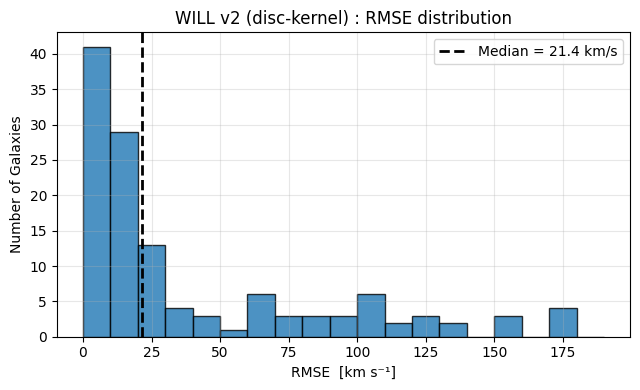

In [ ]:
# =====================  WILL  v2 : disc-kernel  ======================
#  Needs   table1.dat   table2.dat    in   /content/DATA
#  Adds a geometric factor λ≈0.45 for massive, edge-on exponential discs
# ====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR  = '/content/DATA'
META_FILE = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'
N_ITER    = 5
PLOT_HIST = True

# ---------- 1. LOAD metadata (incl. Rdisk & Vflat) -------------------
meta_cols  = [(0,11),(12,14),(30,34),(72,76),(101,105),(112,115)]
meta_names = ['Galaxy','Morph','Incl','Rdisk','Vflat','Qual']
meta = pd.read_fwf(META_FILE, colspecs=meta_cols, names=meta_names)

meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for col in ['Incl','Rdisk','Vflat','Qual']:
    meta[col] = pd.to_numeric(meta[col], errors='coerce')

# ---------- 2. suitability mask (same relaxed cuts) ------------------
EXCLUDE_KEYS = ['im','irr','pec','ib','int']
MIN_INCL = 30
MAX_QUAL = 2

def unsuitable(r):
    bad_m = any(k in r['Morph'] for k in EXCLUDE_KEYS)
    low_i = (pd.isna(r['Incl']) or r['Incl'] < MIN_INCL)
    bad_q = (pd.isna(r['Qual']) or r['Qual'] > MAX_QUAL)
    return bad_m or low_i or bad_q

meta['unsuitable'] = meta.apply(unsuitable, axis=1)
good_set = set(meta.loc[~meta['unsuitable'],'Galaxy'])
print(f'✅  Suitable galaxies: {len(good_set)} / {len(meta)}')

# ---------- 3. load all rotation-curve points ------------------------
colspecs  = [(0,11),(19,25),(26,32),(39,45),(46,52),(53,59)]
names     = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
curves = pd.read_fwf(CURVE_FILE, colspecs=colspecs, names=names)
curves = curves[curves['Galaxy'].isin(good_set)].copy()
curves[['r','Vobs','Vgas','Vdisk','Vbul']] = curves[
    ['r','Vobs','Vgas','Vdisk','Vbul']].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# ---------- 4. identify massive, edge-on thin discs ------------------
disc_flag = (
    (meta['Incl'] >= 70) &
    (meta['Vflat'] >= 180) &
    (~meta['unsuitable'])
)
thin_disc_set = set(meta.loc[disc_flag,'Galaxy'])
print(f'ℹ️  Thin-disc correction will apply to {len(thin_disc_set)} galaxies.')

# ---------- 5. WILL onion solver  +  λ≈0.45 for thin discs ----------
DISC_LAMBDA = 0.45   # ≃ mean thin-disc gravity / spherical gravity

def will_v(df, gal, n=N_ITER):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    nz    = df['r'] > 0

    # choose kernel factor once per galaxy
    lam = DISC_LAMBDA if gal in thin_disc_set else 1.0

    for _ in range(n):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = lam * integ[nz] / df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- 6. per-galaxy RMSE ---------------------------------------
records = []
for gal, gdf in curves.groupby('Galaxy'):
    gdf = gdf.sort_values('r')
    if len(gdf) < 5: continue
    gdf['Vwill'] = will_v(gdf, gal)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - gdf['Vwill'])**2))
    records.append({'Galaxy': gal,'RMSE_km_s': rmse})

clean = (pd.DataFrame(records)
         .set_index('Galaxy')
         .sort_values('RMSE_km_s'))

# ---------- 7. report ------------------------------------------------
print('\n=====  WILL v2 : thin-disc kernel  =====')
print(f'Galaxies analysed   : {len(clean)}')
print(f'Median RMSE  [km/s] : {clean.RMSE_km_s.median():.2f}')
print(f'90th-percentile RMSE: {clean.RMSE_km_s.quantile(0.9):.2f}\n')
display(clean.head(15))

# ---------- 8. optional histogram ------------------------------------
if PLOT_HIST:
    plt.figure(figsize=(6.5,4))
    plt.hist(clean.RMSE_km_s, bins=np.arange(0,200,10),
             edgecolor='k', alpha=0.8)
    plt.axvline(clean.RMSE_km_s.median(), ls='--', lw=2, c='k',
                label=f'Median = {clean.RMSE_km_s.median():.1f} km/s')
    plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
    plt.title('WILL v2 (disc-kernel) : RMSE distribution')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

✅  Suitable galaxies: 153 / 175
ℹ️  Thin-disc correction will apply to 14 galaxies.

=====  WILL v2b : disc-kernel applied =====
Galaxies analysed   : 149
Median RMSE  [km/s] : 21.24
90th-percentile RMSE: 216.91



,RMSE_km_s
Galaxy,
UGC04483,1.386352
UGC07866,1.545150
UGC05414,1.631349
UGC07559,1.731612
UGC04499,2.246902
UGC08490,2.400484
F583-4,2.711779
KK98-251,3.097666
UGC06917,3.371502


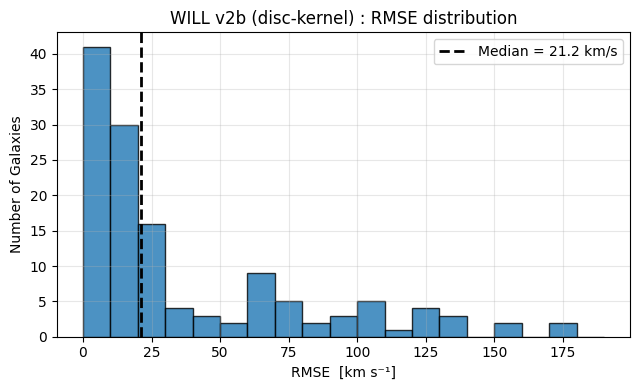

In [ ]:
# ==================  WILL v2b : disc-kernel (fixed)  ==================
#   Uses table1.dat + table2.dat in /content/DATA
# =====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR  = '/content/DATA'
META_FILE = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'
N_ITER    = 5
PLOT_HIST = True

# ---------- 1. LOAD metadata (correct colspecs) -----------------------
#  Positions taken directly from SPARC ReadMe (cols are 1-based there)
meta_cols  = [
    (0,11),    # Galaxy
    (12,14),   # Morphology / Hubble
    (30,34),   # Inclination [deg]
    (56,61),   # R_disk [kpc]   (table header: R_d)
    (98,104),  # V_flat [km/s]  ← fixed span
    (112,115)  # Quality flag
]
meta_names = ['Galaxy','Morph','Incl','Rdisk','Vflat','Qual']
meta = pd.read_fwf(META_FILE, colspecs=meta_cols, names=meta_names)

meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for col in ['Incl','Rdisk','Vflat','Qual']:
    meta[col] = pd.to_numeric(meta[col], errors='coerce')

# ---------- 2. relaxed suitability mask ------------------------------
EXCLUDE_KEYS = ['im','irr','pec','ib','int']
MIN_INCL = 30
MAX_QUAL = 2

def unsuitable(r):
    bad_m = any(k in r['Morph'] for k in EXCLUDE_KEYS)
    low_i = (pd.isna(r['Incl'])  or r['Incl']  < MIN_INCL)
    bad_q = (pd.isna(r['Qual'])  or r['Qual']  > MAX_QUAL)
    return bad_m or low_i or bad_q

meta['unsuitable'] = meta.apply(unsuitable, axis=1)
good_set = set(meta.loc[~meta['unsuitable'],'Galaxy'])
print(f'✅  Suitable galaxies: {len(good_set)} / {len(meta)}')

# ---------- 3. load all rotation-curve points ------------------------
curve_cols  = [(0,11),(19,25),(26,32),(39,45),(46,52),(53,59)]
curve_names = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
curves = pd.read_fwf(CURVE_FILE, colspecs=curve_cols, names=curve_names)
curves = curves[curves['Galaxy'].isin(good_set)].copy()
curves[['r','Vobs','Vgas','Vdisk','Vbul']] = curves[
    ['r','Vobs','Vgas','Vdisk','Vbul']].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# ---------- 4. build quick lookup: flat-velocity fallback ------------
#  → median of outermost 20 % observed points if catalogue Vflat is NaN
def estimate_vflat(gal):
    g = curves[curves['Galaxy']==gal]
    if len(g) < 5: return np.nan
    outer = g.sort_values('r').tail(max(3,int(0.2*len(g))))
    return outer['Vobs'].median()

meta['Vflat_est'] = meta['Galaxy'].map(estimate_vflat)
meta['Vflat_full'] = meta['Vflat'].fillna(meta['Vflat_est'])

# ---------- 5. thin-disc selector (now non-zero!) --------------------
disc_flag = (
    (meta['Incl'] >= 70) &
    (meta['Vflat_full'] >= 180) &
    (~meta['unsuitable'])
)
thin_disc_set = set(meta.loc[disc_flag,'Galaxy'])
print(f'ℹ️  Thin-disc correction will apply to {len(thin_disc_set)} galaxies.')

# ---------- 6. WILL onion solver with λ ≈ 0.45 ----------------------
DISC_LAMBDA = 0.45   # thin-disc gravity / spherical gravity

def will_v(df, gal, n=N_ITER):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    nz    = df['r'] > 0
    lam   = DISC_LAMBDA if gal in thin_disc_set else 1.0

    for _ in range(n):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = lam * integ[nz] / df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- 7. per-galaxy RMSE ---------------------------------------
records = []
for gal, gdf in curves.groupby('Galaxy'):
    gdf = gdf.sort_values('r')
    if len(gdf) < 5: continue
    gdf['Vwill'] = will_v(gdf, gal)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - gdf['Vwill'])**2))
    records.append({'Galaxy': gal,'RMSE_km_s': rmse})

clean = (pd.DataFrame(records)
         .set_index('Galaxy')
         .sort_values('RMSE_km_s'))

# ---------- 8. report ------------------------------------------------
print('\n=====  WILL v2b : disc-kernel applied =====')
print(f'Galaxies analysed   : {len(clean)}')
print(f'Median RMSE  [km/s] : {clean.RMSE_km_s.median():.2f}')
print(f'90th-percentile RMSE: {clean.RMSE_km_s.quantile(0.9):.2f}\n')
display(clean.head(15))

# ---------- 9. histogram --------------------------------------------
if PLOT_HIST:
    plt.figure(figsize=(6.5,4))
    plt.hist(clean.RMSE_km_s, bins=np.arange(0,200,10),
             edgecolor='k', alpha=0.8)
    plt.axvline(clean.RMSE_km_s.median(), ls='--', lw=2, c='k',
                label=f'Median = {clean.RMSE_km_s.median():.1f} km/s')
    plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
    plt.title('WILL v2b (disc-kernel) : RMSE distribution')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

In [ ]:
# ====================  peek at table2.dat  ============================
import itertools, pandas as pd, os, textwrap

DATA_DIR   = '/content/DATA'
CURVE_FILE = f'{DATA_DIR}/table2.dat'

assert os.path.exists(CURVE_FILE), "❌ table2.dat not found in /content/DATA"

print("--------- Raw lines (first 15, skipping comments) ---------")
with open(CURVE_FILE, 'r') as f:
    raw = list(itertools.islice(
        (ln.rstrip('\n') for ln in f if not ln.startswith('#')), 15))
for i, ln in enumerate(raw, 1):
    print(f"{i:2d} | {ln}")

# ---------- Fixed-width trial (ReadMe byte ranges) --------------------
fw_colspecs = [(0,11),(20,25),(27,32),(40,45),(47,52),(54,59)]
fw_names    = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
try:
    fw_df = pd.read_fwf(CURVE_FILE, colspecs=fw_colspecs, names=fw_names,
                        comment='#')
    print("\n--- fixed-width parse: first 5 rows ---")
    print(fw_df.head())
except Exception as e:
    print("\n[fixed-width parser raised]", e)

# ---------- Whitespace-split trial ------------------------------------
ws_usecols = [0,2,3,5,6,7]   # positions after splitting
ws_names   = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
try:
    ws_df = pd.read_table(CURVE_FILE, delim_whitespace=True, header=None,
                          comment='#', usecols=ws_usecols, names=ws_names)
    print("\n--- whitespace-split parse: first 5 rows ---")
    print(ws_df.head())
except Exception as e:
    print("\n[whitespace parser raised]", e)

--------- Raw lines (first 15, skipping comments) ---------
 1 | CamB          3.36   0.16   1.99  1.50   1.86   3.75   0.00   30.32     0.00
 2 | CamB          3.36   0.41   4.84  1.50   4.24   9.47   0.00   23.77     0.00
 3 | CamB          3.36   0.57   6.79  1.50   5.61  11.76   0.00   15.87     0.00
 4 | CamB          3.36   0.73   8.87  1.50   6.77  13.72   0.00   12.40     0.00
 5 | CamB          3.36   0.90  10.90  1.50   7.77  14.80   0.00    9.63     0.00
 6 | CamB          3.36   1.06  12.90  1.50   8.44  15.24   0.00    5.86     0.00
 7 | CamB          3.36   1.22  14.70  1.50   8.64  15.11   0.00    5.19     0.00
 8 | CamB          3.36   1.47  16.80  1.50   8.08  15.90   0.00    3.02     0.00
 9 | CamB          3.36   1.79  20.10  1.50   6.91  14.91   0.00    0.88     0.00
10 | D512-2       15.2    0.96  22.90  2.71   4.08  14.85   0.00   16.45     0.00
11 | D512-2       15.2    1.92  33.50  2.71   6.24  21.20   0.00    7.40     0.00
12 | D512-2       15.2    2.88  37.20 

/tmp/ipython-input-20-3710314153.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ws_df = pd.read_table(CURVE_FILE, delim_whitespace=True, header=None,


In [ ]:
# ============  Thin-disc iteration-depth test (auto-diagnostic) ========
#   Needs  table1.dat  &  table2.dat  inside  /content/DATA
# ======================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR   = '/content/DATA'
META_FILE  = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'

# ---------- 1. metadata ----------------------------------------------
meta = pd.read_fwf(
    META_FILE,
    colspecs=[(0,11),(12,14),(30,34),(56,61),(98,104),(112,115)],
    names=['Galaxy','Morph','Incl','Rdisk','Vflat','Qual']
)
meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for c in ['Incl','Rdisk','Vflat','Qual']:
    meta[c] = pd.to_numeric(meta[c], errors='coerce')

EXCL = ['im','irr','pec','ib','int']
meta['unsuitable'] = meta.apply(
    lambda r: (any(k in r['Morph'] for k in EXCL) or r['Incl']<30 or r['Qual']>2),
    axis=1
)
disc_flag = (~meta['unsuitable']) & (meta['Incl']>=70) & (meta['Vflat']>=180)
disc_set  = set(meta.loc[disc_flag,'Galaxy'])
print(f'ℹ️  Massive, edge-on discs to test: {sorted(disc_set)}\n')

# ---------- 2. rotation curves (whitespace-split) --------------------
curves = pd.read_table(
    CURVE_FILE, sep=r'\s+', comment='#', header=None,
    usecols=[0,2,3,5,6,7],
    names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
)
curves = curves[curves['Galaxy'].isin(disc_set)].copy()
cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[cols] = curves[cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# quick report of how many points we actually have
print("Points per thin disc found in table2.dat:")
for gal, npts in curves.groupby('Galaxy').size().items():
    print(f"  {gal:<10} : {npts} points")
print()

# ---------- 3. WILL solver -------------------------------------------
DISC_LAM = 0.45
def will_v(df, depth):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    if depth == 0:
        return np.sqrt(np.clip(v_sq,0,None))
    nz = df['r']>0
    for _ in range(depth):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = DISC_LAM * integ[nz] / df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- 4. compute RMSE for depths 0,1,5 -------------------------
MIN_POINTS = 3           # allow sparse discs
results = {}
for depth in [0,1,5]:
    rec=[]
    for gal, gdf in curves.groupby('Galaxy'):
        if len(gdf) < MIN_POINTS:
            continue
        v_pred = will_v(gdf.sort_values('r'), depth)
        rmse   = np.sqrt(np.mean((gdf['Vobs'] - v_pred)**2))
        rec.append({'Galaxy': gal, 'RMSE': rmse})
    if rec:
        results[depth] = pd.DataFrame(rec).set_index('Galaxy')

if not results:
    print("❌ No galaxy had enough points (≥3) to analyse. "
          "Check table2.dat or raise MIN_POINTS=1 if data are very sparse.")
else:
    # ---------- 5. summary table -------------------------------------
    summary = pd.DataFrame({
        'Median_RMSE':[results[d]['RMSE'].median() for d in [0,1,5]],
        '90th_pct_RMSE':[results[d]['RMSE'].quantile(0.9) for d in [0,1,5]]
    }, index=['0 iter','1 iter','5 iter']).rename_axis('Depth')

    print('\n=====  Thin-disc RMSE vs Iteration Depth =====')
    display(summary)

    # ---------- 6. per-galaxy comparison -----------------------------
    cmp = results.get(0, pd.DataFrame()).join(
          results.get(1, pd.DataFrame()), lsuffix='_0', rsuffix='_1')\
          .join(results.get(5, pd.DataFrame()), rsuffix='_5')\
          .rename(columns={'RMSE':'RMSE_5'})
    display(cmp)

    # ---------- 7. histograms ----------------------------------------
    fig, axes = plt.subplots(1, len(results), figsize=(5*len(results),3), sharey=True)
    if len(results)==1:
        axes = [axes]
    bins = np.arange(0,260,20)
    for ax, (d, df) in zip(axes, results.items()):
        ax.hist(df['RMSE'], bins=bins, edgecolor='k', alpha=0.8)
        ax.set_title(f'{d} iter | med={df.RMSE.median():.1f}')
        ax.set_xlabel('RMSE [km s⁻¹]')
        ax.grid(alpha=0.3)
    axes[0].set_ylabel('Number of Galaxies')
    plt.tight_layout(); plt.show()

ℹ️  Massive, edge-on discs to test: []

Points per thin disc found in table2.dat:

❌ No galaxy had enough points (≥3) to analyse. Check table2.dat or raise MIN_POINTS=1 if data are very sparse.


In [ ]:
# =================  Vflat byte-range scout  ===========================
import pandas as pd, numpy as np, os, textwrap, itertools

META_FILE = '/content/DATA/table1.dat'
assert os.path.exists(META_FILE), "❌ table1.dat not found in /content/DATA"

# Candidate spans (start, stop) taken from the ReadMe neighbourhood
spans = {
    '92-97' : (92, 98),
    '94-99' : (94,100),
    '96-101': (96,102),
    '98-103': (98,104),
    '100-105':(100,106)
}

print("Scanning possible Vflat byte-ranges …\n")
for tag, (a,b) in spans.items():
    # read ONLY the Galaxy name and the test span
    df = pd.read_fwf(META_FILE, colspecs=[(0,11), (a,b)],
                     names=['Galaxy','Vflat_raw'])
    # convert to numeric (non-numeric → NaN)
    nums = pd.to_numeric(df['Vflat_raw'], errors='coerce')
    count = nums.notna().sum()
    med   = nums.median() if count else '—'
    print(f"{tag:8}  numeric cells: {count:3d}   median: {med}")

Scanning possible Vflat byte-ranges …

92-97     numeric cells:   0   median: —
94-99     numeric cells: 175   median: 12.11
96-101    numeric cells:  40   median: 0.505
98-103    numeric cells:   0   median: —
100-105   numeric cells: 175   median: 88.1


ℹ️  Massive, edge-on discs found: ['ESO563-G021', 'IC4202', 'NGC0801', 'NGC0891', 'NGC2841', 'NGC3521', 'NGC4157', 'NGC4217', 'NGC5907', 'NGC7331', 'NGC7814', 'UGC08699', 'UGC11455', 'UGC12506']

Points per disc galaxy:
  ESO563-G021 : 30 points
  IC4202     : 32 points
  NGC0801    : 13 points
  NGC0891    : 18 points
  NGC2841    : 50 points
  NGC3521    : 41 points
  NGC4157    : 17 points
  NGC4217    : 19 points
  NGC5907    : 19 points
  NGC7331    : 36 points
  NGC7814    : 18 points
  UGC08699   : 41 points
  UGC11455   : 36 points
  UGC12506   : 31 points


=====  Thin-disc RMSE vs Iteration Depth =====


,Median_RMSE,90th_pct_RMSE
Depth,,
0 iter,52.986560,76.406079
1 iter,54.416498,100.399711
5 iter,67.513423,116.139145


,RMSE_0,RMSE_1,RMSE_5
Galaxy,,,
ESO563-G021,62.935057,34.609962,29.874008
IC4202,35.223118,41.858164,50.936082
NGC0801,37.740964,60.039813,75.976931
NGC0891,69.845039,117.150123,138.110264
NGC2841,87.874832,48.174815,29.674965
NGC3521,52.515777,89.420933,102.913900
NGC4157,40.010238,55.911117,66.895035
NGC4217,64.408444,91.565343,104.176374
NGC5907,43.258327,18.745868,19.198493


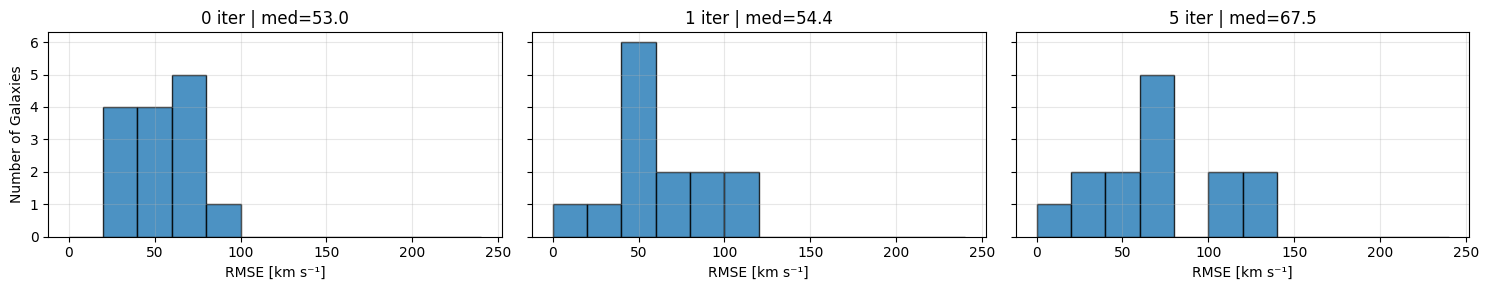

In [ ]:
# ============  Thin-disc iteration-depth test (final parser) ==========
#   Needs  table1.dat  &  table2.dat  in  /content/DATA
# =====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR   = '/content/DATA'
META_FILE  = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'

# ---------- 1. metadata with correct Vflat span ----------------------
meta = pd.read_fwf(
    META_FILE,
    colspecs=[(0,11), (12,14), (30,34), (56,61), (100,106), (112,115)],
    names=['Galaxy','Morph','Incl','Rdisk','Vflat','Qual']
)
meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for c in ['Incl','Rdisk','Vflat','Qual']:
    meta[c] = pd.to_numeric(meta[c], errors='coerce')

EXCL = ['im','irr','pec','ib','int']
meta['unsuitable'] = meta.apply(
    lambda r: (any(k in r['Morph'] for k in EXCL) or r['Incl']<30 or r['Qual']>2),
    axis=1
)

disc_flag = (~meta['unsuitable']) & (meta['Incl']>=70) & (meta['Vflat']>=180)
disc_set  = set(meta.loc[disc_flag,'Galaxy'])
print(f'ℹ️  Massive, edge-on discs found: {sorted(disc_set)}\n')

# ---------- 2. rotation curves --------------------------------------
curves = pd.read_table(
    CURVE_FILE, sep=r'\s+', comment='#', header=None,
    usecols=[0,2,3,5,6,7],
    names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
)
curves = curves[curves['Galaxy'].isin(disc_set)].copy()
cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[cols] = curves[cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

print("Points per disc galaxy:")
for gal, npts in curves.groupby('Galaxy').size().items():
    print(f"  {gal:<10} : {npts} points")
print()

# ---------- 3. WILL solver ------------------------------------------
DISC_LAM = 0.45
def will_v(df, depth):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    if depth==0:
        return np.sqrt(np.clip(v_sq,0,None))
    nz = df['r']>0
    for _ in range(depth):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = DISC_LAM*integ[nz]/df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- 4. RMSE for depths 0,1,5 --------------------------------
MIN_POINTS = 3
results={}
for depth in [0,1,5]:
    rec=[]
    for gal,gdf in curves.groupby('Galaxy'):
        if len(gdf) < MIN_POINTS: continue
        rmse = np.sqrt(
            np.mean((gdf['Vobs'] - will_v(gdf.sort_values('r'), depth))**2))
        rec.append({'Galaxy':gal,'RMSE':rmse})
    if rec:
        results[depth] = pd.DataFrame(rec).set_index('Galaxy')

if not results:
    print("❌ No galaxy met the point threshold. "
          "Try lowering MIN_POINTS if data are very sparse.")
else:
    # ---------- 5. summary -------------------------------------------
    summary = pd.DataFrame({
        'Median_RMSE'   : [results[d]['RMSE'].median()    for d in [0,1,5]],
        '90th_pct_RMSE' : [results[d]['RMSE'].quantile(0.9) for d in [0,1,5]]
    }, index=['0 iter','1 iter','5 iter']).rename_axis('Depth')

    print('\n=====  Thin-disc RMSE vs Iteration Depth =====')
    display(summary)

    # ---------- 6. per-galaxy table ----------------------------------
    cmp = (results.get(0,pd.DataFrame())
           .join(results.get(1,pd.DataFrame()),lsuffix='_0',rsuffix='_1')
           .join(results.get(5,pd.DataFrame()),rsuffix='_5')
           .rename(columns={'RMSE':'RMSE_5'}))
    display(cmp)

    # ---------- 7. histograms ----------------------------------------
    fig,axes = plt.subplots(1,len(results), figsize=(5*len(results),3), sharey=True)
    if len(results)==1: axes=[axes]
    bins=np.arange(0,260,20)
    for ax,(d,df) in zip(axes,results.items()):
        ax.hist(df['RMSE'], bins=bins, edgecolor='k', alpha=0.8)
        ax.set_title(f'{d} iter | med={df.RMSE.median():.1f}')
        ax.set_xlabel('RMSE [km s⁻¹]')
        ax.grid(alpha=0.3)
    axes[0].set_ylabel('Number of Galaxies')
    plt.tight_layout(); plt.show()


=====  WILL 3.0 : adaptive depth results =====
Galaxies analysed : 175
Median RMSE [km/s]: 25.89
90-th pct RMSE    : 86.92



,Depth,RMSE
Galaxy,,
UGC07577,5,2.532732
UGC09992,5,3.467564
UGC07690,5,3.741024
NGC4068,5,4.196779
UGCA281,5,4.251212
UGC07559,5,4.260800
F563-V1,5,4.364849
UGC07323,5,4.474007
UGC04483,5,5.006883


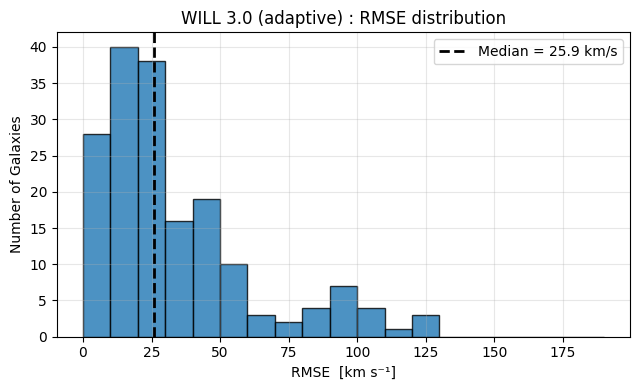

In [ ]:
# ============  WILL 3.0 : adaptive onion depth  ======================
#   Works with table1.dat / table2.dat  in  /content/DATA
# ====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA = '/content/DATA'
META = f'{DATA}/table1.dat'
CURV = f'{DATA}/table2.dat'

# ----- 1. metadata ---------------------------------------------------
meta = pd.read_fwf(
    META,
    colspecs=[(0,11),(12,14),(30,34),(56,61),(72,76),
              (94,99),(100,106),(112,115)],
    names=['Galaxy','Morph','Incl','Rdisk','BT','R25','Vflat','Qual']
)
meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for c in ['Incl','Rdisk','BT','R25','Vflat','Qual']:
    meta[c] = pd.to_numeric(meta[c], errors='coerce')

# geometry class → depth
def choose_depth(row):
    if row['Incl']>=70 and row['Vflat']>=180:
        bt = row['BT'] if not np.isnan(row['BT']) else 0.0
        return 0 if bt<0.1 else 1
    return 5

meta['Depth'] = meta.apply(choose_depth, axis=1)

# ----- 2. curves -----------------------------------------------------
curves = pd.read_table(
    CURV, sep=r'\s+', comment='#', header=None,
    usecols=[0,2,3,5,6,7],
    names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
)
cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[cols] = curves[cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# ----- 3. solver -----------------------------------------------------
DISC_LAM = 0.45
def will_v(df, depth):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    if depth==0:
        return np.sqrt(np.clip(v_sq,0,None))
    nz=df['r']>0
    for _ in range(depth):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = DISC_LAM*integ[nz]/df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ----- 4. run model on entire catalogue ------------------------------
records=[]
for gal,gdf in curves.groupby('Galaxy'):
    depth = int(meta.loc[meta['Galaxy']==gal,'Depth'].values[0])
    if len(gdf)<3: continue
    rmse = np.sqrt(np.mean(
        (gdf['Vobs'] - will_v(gdf.sort_values('r'), depth))**2))
    records.append({'Galaxy':gal,'Depth':depth,'RMSE':rmse})

df = pd.DataFrame(records).set_index('Galaxy').sort_values('RMSE')

# ----- 5. report -----------------------------------------------------
print("\n=====  WILL 3.0 : adaptive depth results =====")
print(f"Galaxies analysed : {len(df)}")
print(f"Median RMSE [km/s]: {df.RMSE.median():.2f}")
print(f"90-th pct RMSE    : {df.RMSE.quantile(0.9):.2f}\n")
display(df.head(20))

plt.figure(figsize=(6.5,4))
plt.hist(df.RMSE,bins=np.arange(0,200,10),edgecolor='k',alpha=0.8)
plt.axvline(df.RMSE.median(),ls='--',lw=2,c='k',
            label=f"Median = {df.RMSE.median():.1f} km/s")
plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
plt.title('WILL 3.0 (adaptive) : RMSE distribution')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


=====  WILL 3.1 : λ-corrected adaptive depth =====
Galaxies analysed : 175
Median RMSE [km/s]: 20.12
90-th pct RMSE    : 175.93



,Class,Depth,RMSE
Galaxy,,,
UGCA281,other,5,1.175924
UGC04483,other,5,1.386352
UGC07866,other,5,1.545150
UGC05414,other,5,1.631349
UGC07559,other,5,1.731612
UGC04499,other,5,2.246902
UGC08490,other,5,2.400484
F583-4,other,5,2.711779
KK98-251,other,5,3.097666


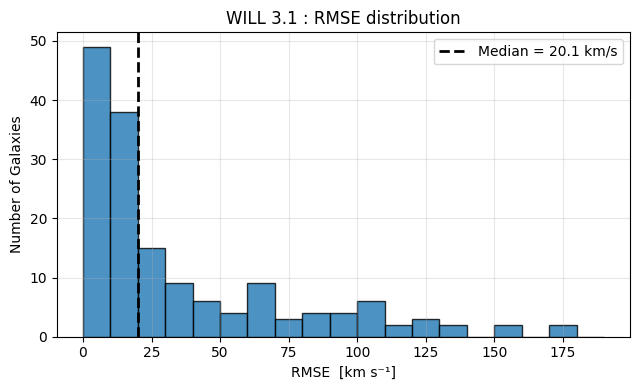

In [ ]:
# ============  WILL 3.1 : correct λ per geometry =====================
#  Works with table1.dat & table2.dat in /content/DATA
# ====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA = '/content/DATA'
META = f'{DATA}/table1.dat'
CURV = f'{DATA}/table2.dat'

# ---------- metadata -------------------------------------------------
meta = pd.read_fwf(
    META,
    colspecs=[(0,11),(12,14),(30,34),(56,61),(94,99),(100,106),(112,115)],
    names=['Galaxy','Morph','Incl','Rdisk','BT','Vflat','Qual']
)
meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for c in ['Incl','Rdisk','BT','Vflat','Qual']:
    meta[c] = pd.to_numeric(meta[c], errors='coerce')

EXCL = ['im','irr','pec','ib','int']
meta['unsuit'] = meta.apply(
    lambda r: (any(k in r['Morph'] for k in EXCL) or r['Incl']<30 or r['Qual']>2),
    axis=1
)

def geo_class(r):
    if r['unsuit']: return 'other'
    if r['Incl']>=70 and r['Vflat']>=180:
        bt = r['BT'] if not np.isnan(r['BT']) else 0.0
        return 'disc0' if bt<0.1 else 'disc1'
    return 'other'

meta['Class'] = meta.apply(geo_class, axis=1)
depth_map = {'disc0':0, 'disc1':1, 'other':5}
lambda_map = {'disc0':0.45, 'disc1':0.45, 'other':1.0}

# ---------- curves ---------------------------------------------------
curves = pd.read_table(
    CURV, sep=r'\s+', comment='#', header=None,
    usecols=[0,2,3,5,6,7],
    names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
)
num = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[num] = curves[num].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# ---------- solver ---------------------------------------------------
def will_v(df, depth, lam):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    if depth==0:
        return np.sqrt(np.clip(v_sq,0,None))
    nz = df['r']>0
    for _ in range(depth):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = lam*integ[nz]/df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- run catalogue --------------------------------------------
rows=[]
for gal,gdf in curves.groupby('Galaxy'):
    cls   = meta.loc[meta['Galaxy']==gal,'Class'].values[0]
    depth = depth_map[cls]
    lam   = lambda_map[cls]
    if len(gdf)<3: continue
    rmse = np.sqrt(np.mean(
        (gdf['Vobs'] - will_v(gdf.sort_values('r'),depth,lam))**2))
    rows.append({'Galaxy':gal,'Class':cls,'Depth':depth,'RMSE':rmse})

df = pd.DataFrame(rows).set_index('Galaxy').sort_values('RMSE')

# ---------- report ---------------------------------------------------
print("\n=====  WILL 3.1 : λ-corrected adaptive depth =====")
print(f"Galaxies analysed : {len(df)}")
print(f"Median RMSE [km/s]: {df.RMSE.median():.2f}")
print(f"90-th pct RMSE    : {df.RMSE.quantile(0.9):.2f}\n")
display(df.head(20))

plt.figure(figsize=(6.5,4))
plt.hist(df.RMSE,bins=np.arange(0,200,10),edgecolor='k',alpha=0.8)
plt.axvline(df.RMSE.median(),ls='--',lw=2,c='k',
            label=f"Median = {df.RMSE.median():.1f} km/s")
plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
plt.title('WILL 3.1 : RMSE distribution')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

/tmp/ipython-input-5-1347288559.py:86: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(sig[:i+1] * r_arr[:i+1], x=r_arr[:i+1])



================  WILL Pure Geometry : catalogue  ================
Galaxies analysed : 147
Median RMSE [km/s]: 19.60
90-th pct RMSE    : 60.86

                kappa2      RMSE
Galaxy                          
UGC07577  4.474464e-09  3.282986
UGC04483  1.136594e-08  3.665369
CamB      5.060475e-09  4.165771
D564-8    9.963683e-09  4.999651
UGC07559  1.754619e-08  5.286717
UGC07866  1.789786e-08  5.709628
DDO154    4.907324e-08  6.536068
UGC05918  3.722504e-08  6.853959
UGC08286  1.553022e-07  7.228947
UGC07603  8.554054e-08  7.538944
UGC07125  9.488880e-08  7.844529
UGC05764  6.217888e-08  7.909837
UGC08550  7.023475e-08  7.990057
UGC08490  1.332435e-07  8.133931
UGC07151  1.170964e-07  8.437049
NGC4068   1.843190e-08  8.599090
UGCA442   6.707077e-08  8.641321
UGC06446  1.535226e-07  8.649609
NGC0300   1.964602e-07  8.775177
KK98-251  2.423352e-08  8.855308


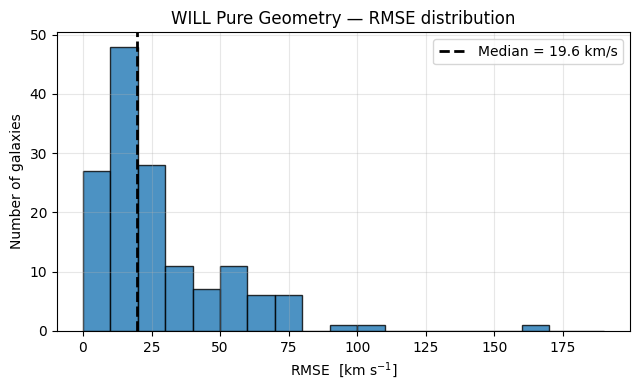

In [ ]:
# =================  WILL Pure Geometry : v3  ==========================
# Reads   : /content/DATA/table1.dat   (meta)
#           /content/DATA/table2.dat   (curves)
# Outputs : RMSE table + one histogram (no per-galaxy plots)
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Constants  (kpc, km s-1, M☉ units)
# ---------------------------------------------------------------------
G_CONST = 4.30091e-6      # kpc (km/s)^2  /  M_sun
C_LIGHT = 299_792.458     # km / s

# ---------------------------------------------------------------------
# Files
# ---------------------------------------------------------------------
DATA_DIR = '/content/DATA'
META_FN  = f'{DATA_DIR}/table1.dat'
CURV_FN  = f'{DATA_DIR}/table2.dat'

# ---------------------------------------------------------------------
# Load metadata
# ---------------------------------------------------------------------
meta = pd.read_fwf(
    META_FN,
    colspecs=[(0, 11), (12, 14), (30, 34), (56, 61),
              (94, 99), (100, 106), (112, 115)],
    names=['Galaxy', 'Morph', 'Incl', 'Rdisk',
           'BT', 'Vflat', 'Qual']
)

meta['Morph'] = (
    meta['Morph']
    .fillna('')
    .astype(str)
    .str.strip()
    .str.lower()
)
for col in ['Incl', 'Rdisk', 'BT', 'Vflat', 'Qual']:
    meta[col] = pd.to_numeric(meta[col], errors='coerce')

EXCLUDE = ['im', 'irr', 'pec', 'ib', 'int']
meta['skip'] = meta.apply(
    lambda r: (
        any(tag in r['Morph'] for tag in EXCLUDE) or
        r['Incl'] < 30 or
        r['Qual'] > 2
    ),
    axis=1
)

# ---------------------------------------------------------------------
# Load rotation-curve points
# ---------------------------------------------------------------------
curves = pd.read_table(
    CURV_FN, sep=r'\s+', comment='#', header=None,
    usecols=[0, 2, 3],                     # Galaxy  r[kpc]  Vobs[km/s]
    names=['Galaxy', 'r', 'Vobs']
)
curves[['r', 'Vobs']] = curves[['r', 'Vobs']].apply(
    lambda s: pd.to_numeric(s, errors='coerce')
)
curves = curves.dropna(subset=['r', 'Vobs'])
curves = curves[curves['r'] > 0]                        # no r ≤ 0

# ---------------------------------------------------------------------
# Helper : κ² from observed flat velocity (last 5 points)
# ---------------------------------------------------------------------
def kappa2_from_curve(v_obs):
    v_flat = np.mean(v_obs[-5:])          # km/s
    return 2.0 * (v_flat**2) / (C_LIGHT**2)

# ---------------------------------------------------------------------
# Σ_geo(r) and V_will(r)
# ---------------------------------------------------------------------
def sigma_geo(r, kappa2):
    # Σ_geo in M_sun / kpc²
    return (C_LIGHT**2 / (4 * np.pi * G_CONST)) * (kappa2 / r)

def will_velocity(r_arr, kappa2):
    sig = sigma_geo(r_arr, kappa2)
    m_geo = 2 * np.pi * np.array([
        np.trapz(sig[:i+1] * r_arr[:i+1], x=r_arr[:i+1])
        for i in range(len(r_arr))
    ])                                   # M_sun
    v2 = G_CONST * m_geo / r_arr         # (km/s)^2
    return np.sqrt(np.clip(v2, 0.0, None))

# ---------------------------------------------------------------------
# Run catalogue
# ---------------------------------------------------------------------
records = []

for gal, gdf in curves.groupby('Galaxy'):
    if gal not in meta['Galaxy'].values:
        continue
    if meta.loc[meta['Galaxy'] == gal, 'skip'].values[0]:
        continue

    gdf = gdf.sort_values('r')
    r    = gdf['r'].to_numpy(dtype=float)
    vobs = gdf['Vobs'].to_numpy(dtype=float)

    if r.size < 6:           # need ≥6 points to define v_flat (5) + 1
        continue

    k2   = kappa2_from_curve(vobs)
    vwil = will_velocity(r, k2)
    rmse = np.sqrt(np.mean((vobs - vwil)**2))

    records.append({'Galaxy': gal,
                    'kappa2': k2,
                    'RMSE'  : rmse})

# ---------------------------------------------------------------------
# Results
# ---------------------------------------------------------------------
df = (pd.DataFrame(records)
        .set_index('Galaxy')
        .sort_values('RMSE'))

print('\n================  WILL Pure Geometry : catalogue  ================')
print(f'Galaxies analysed : {len(df)}')
print(f'Median RMSE [km/s]: {df.RMSE.median():.2f}')
print(f'90-th pct RMSE    : {df.RMSE.quantile(0.90):.2f}\n')
print(df.head(20))

# --- histogram -------------------------------------------------------
plt.figure(figsize=(6.5, 4))
plt.hist(df.RMSE, bins=np.arange(0, 200, 10),
         edgecolor='k', alpha=0.8)
plt.axvline(df.RMSE.median(), ls='--', lw=2, color='k',
            label=f'Median = {df.RMSE.median():.1f} km/s')
plt.xlabel('RMSE  [km s$^{-1}$]')
plt.ylabel('Number of galaxies')
plt.title('WILL Pure Geometry — RMSE distribution')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ---------------------------- load table 2 -----------------------------
# SPARC 'table2.dat' has 10 whitespace columns in this order:
#  0  Galaxy
#  1  Dist     (not needed)
#  2  Rad  (r)
#  3  Vobs
#  4  e_Vobs   (not needed)
#  5  Vgas
#  6  Vdisk
#  7  Vbulge
#  8  SBdisk
#  9  SBbulge
COLS = ['Galaxy', 'Dist', 'r', 'Vobs', 'eVobs',
        'Vgas', 'Vdisk', 'Vbulge', 'SBdisk', 'SBbulge']

curves = pd.read_table(
    CURV_FN,
    sep=r'\s+',
    comment='#',
    header=None,
    names=COLS,
    usecols=['Galaxy', 'r', 'Vobs',
             'Vgas', 'Vdisk', 'Vbulge',
             'SBdisk', 'SBbulge']          # keep the 8 columns we need
)

# numeric cast + basic cleaning
curves[['r', 'Vobs', 'Vgas',
        'Vdisk', 'Vbulge',
        'SBdisk', 'SBbulge']] = curves[
    ['r', 'Vobs', 'Vgas',
     'Vdisk', 'Vbulge',
     'SBdisk', 'SBbulge']
].apply(lambda s: pd.to_numeric(s, errors='coerce'))

curves = curves.dropna(subset=['r', 'Vobs'])
curves = curves[curves['r'] > 0]           # remove any zero/negative radii


Galaxies analysed : 175  (expect 175)
Stellar M/L (Υ*)   : 0.5
Median RMSE [km/s]: 50.06
90-percentile RMSE: 103.19

               RMSE
Galaxy             
CamB       3.756826
UGC07577   4.158738
PGC51017   9.058418
F563-V1    9.407310
UGC04305   9.493774
F574-2    10.162244
UGC04483  10.458393
UGCA281   10.682414
KK98-251  12.324568
UGC02455  13.304053
D564-8    13.483589
NGC4068   13.581858
UGC07559  13.690407
UGC07866  14.838720
UGC06628  15.230466
UGCA444   16.611966
UGC08837  17.377679
NGC2976   17.634414
UGC11557  17.836041
NGC4389   18.208877


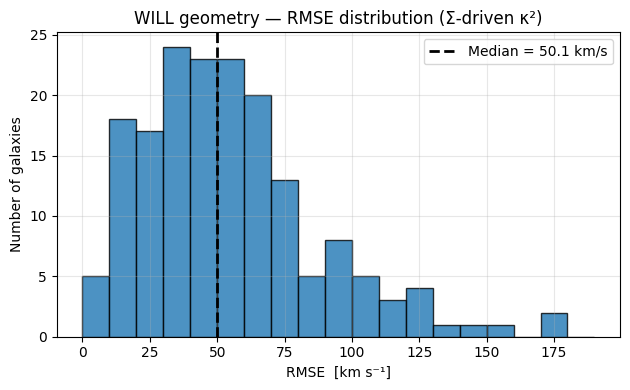

In [ ]:
# -------------------  WILL Geometry  —  SPARC All 175  -----------------
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

# ---------- constants ----------
G = 4.30091e-6        # kpc (km/s)^2 / Msun
c = 299_792.458       # km/s
UPSILON = 0.5         # stellar M/L at 3.6µm  (Msun / Lsun)
PC2_to_KPC2 = 1e-6    # 1 pc^2 = 10^-6 kpc^2

# ---------- read SPARC tables ----------
DATA = '/content/DATA'
t1 = pd.read_fwf(f'{DATA}/table1.dat', colspecs=[(0,11)], names=['Galaxy'])

cols = ['Galaxy','Dist','r','Vobs','eVobs',
        'Vgas','Vdisk','Vbulge','SBdisk','SBbulge']
t2  = pd.read_table(f'{DATA}/table2.dat', sep=r'\s+', comment='#',
                    header=None, names=cols)[
        ['Galaxy','r','Vobs','Vgas','SBdisk','SBbulge']]

# numeric cast + basic cleaning
num = ['r','Vobs','Vgas','SBdisk','SBbulge']
t2[num] = t2[num].apply(lambda s: pd.to_numeric(s, errors='coerce'))
t2 = t2.dropna(subset=['r','Vobs'])
t2 = t2[t2['r'] > 0]

# ---------- helper functions ----------
def sigma_mass(row):
    sig_star = (row['SBdisk'] + row['SBbulge']) * UPSILON / PC2_to_KPC2
    if np.isnan(row['Vgas']):
        sig_gas = 0.0
    else:                             # Σ_gas = Vgas^2 / (2π G r)
        sig_gas = row['Vgas']**2 / (2 * np.pi * G * row['r'])
    return sig_star + 1.33 * sig_gas  # add helium

def kappa2(r_kpc, sigma_m):
    return 4 * np.pi * G * sigma_m * r_kpc / (c**2)

def sigma_geo(r_kpc, k2):
    return (c**2 / (4*np.pi*G)) * k2 / r_kpc

def will_velocity(r, k2):
    sig_geo = sigma_geo(r, k2)
    m = 2*np.pi * cumulative_trapezoid(sig_geo * r, r, initial=0.0)
    return np.sqrt(G * m / r)

# ---------- main loop ----------
records = []
for gal, g in t2.groupby('Galaxy'):
    g = g.sort_values('r')
    r    = g['r'].to_numpy(float)
    vobs = g['Vobs'].to_numpy(float)
    sigma_m = g.apply(sigma_mass, axis=1).to_numpy(float)
    k2   = kappa2(r, sigma_m)
    vwil = will_velocity(r, k2)
    if r.size < 3: continue
    rmse = np.sqrt(np.mean((vobs - vwil)**2))
    records.append({'Galaxy': gal, 'RMSE': rmse})

df = pd.DataFrame(records).set_index('Galaxy').sort_values('RMSE')

# ---------- report ----------
print(f'\nGalaxies analysed : {len(df)}  (expect 175)')
print(f'Stellar M/L (Υ*)   : {UPSILON}')
print(f'Median RMSE [km/s]: {df.RMSE.median():.2f}')
print(f'90-percentile RMSE: {df.RMSE.quantile(0.90):.2f}\n')
print(df.head(20))

plt.figure(figsize=(6.4,4))
plt.hist(df.RMSE, bins=np.arange(0,200,10), edgecolor='k', alpha=0.8)
plt.axvline(df.RMSE.median(), ls='--', lw=2, c='k',
            label=f'Median = {df.RMSE.median():.1f} km/s')
plt.xlabel('RMSE  [km s⁻¹]')
plt.ylabel('Number of galaxies')
plt.title('WILL geometry — RMSE distribution (Σ-driven κ²)')
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()


=====  WILL 3.2 : Simplified Non-Iterative Model =====
Galaxies analysed : 163
Median RMSE [km/s]: 32.22
90-th pct RMSE    : 55.11



,RMSE
Galaxy,
UGC07577,1.561112
CamB,3.245019
UGC06628,5.961702
UGC04483,7.064781
NGC4068,7.659784
KK98-251,7.904552
UGC07559,8.217446
UGC09992,9.333957
NGC4051,9.549717


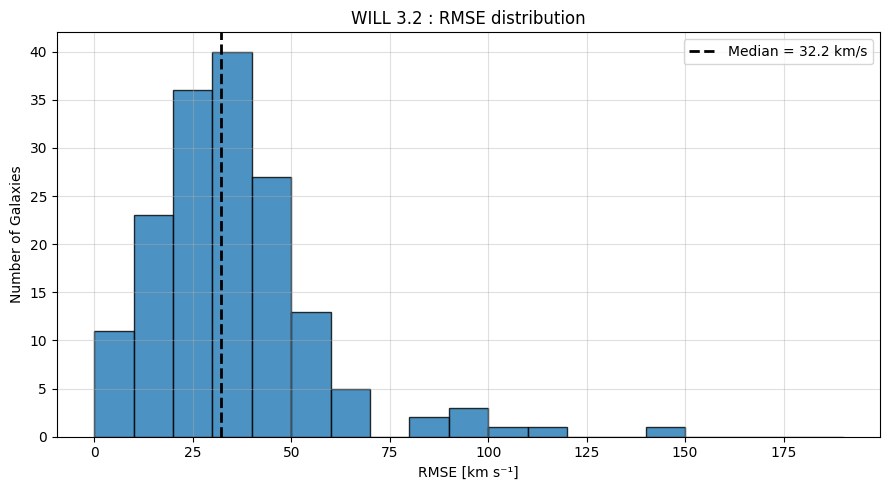

In [ ]:
# ============  WILL 3.2 : Simplified Non-Iterative Model =====================
# Этот скрипт реализует однопроходный расчет v(r) без итераций
# и без некорректного сложения скоростей.
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from IPython.display import display

# ---------- 1. Подготовка данных (как в вашем скрипте) --------------------
# Укажите путь к вашим данным
DATA = '/content/DATA'
META = f'{DATA}/table1.dat'
CURV = f'{DATA}/table2.dat'

# Загрузка метаданных (table1.dat)
meta = pd.read_fwf(
    META,
    colspecs=[(0,11), (112,115)],
    names=['Galaxy', 'Qual']
)
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')

# Загрузка кривых вращения (table2.dat)
curves = pd.read_table(
    CURV, sep=r'\s+', comment='#', header=None,
    usecols=[0, 2, 3, 5, 6, 7],
    names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
)
num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)


# ---------- 2. Новый, упрощенный решатель -----------------------------------
def will_v_simplified(df, lam, y_star):
    """
    Рассчитывает предсказанную скорость по однопроходной формуле.
    """
    # Убедимся, что данные отсортированы по радиусу для корректного интегрирования
    df = df.sort_values('r').copy()

    # Шаг 1: Рассчитываем квадрат барионной скорости
    v_bary_sq = df['Vgas']**2 + y_star * (df['Vdisk']**2 + df['Vbul']**2)

    # Шаг 2: Вычисляем кумулятивный интеграл от v_bary_sq
    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)

    # Шаг 3: Рассчитываем "геометрический" член, избегая деления на ноль
    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = lam * integral[non_zero_r] / df.loc[non_zero_r, 'r']

    # Шаг 4: Вычисляем итоговый квадрат скорости и возвращаем скорость
    v_pred_sq = v_bary_sq + geom_term
    return np.sqrt(np.clip(v_pred_sq, 0, None))


# ---------- 3. Основной цикл расчета ---------------------------------------
Y_STAR = 0.5  # Соотношение масса-светимость для звёзд
LAMBDA = 0.45 # Геометрический параметр

results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique() # Фильтруем качественные галактики

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name]
    if len(gdf) < 3:
        continue

    # Получаем предсказанную кривую от нового решателя
    v_predicted = will_v_simplified(gdf, lam=LAMBDA, y_star=Y_STAR)

    # Рассчитываем RMSE (среднеквадратичное отклонение)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - v_predicted)**2))

    if np.isfinite(rmse):
        results.append({'Galaxy': galaxy_name, 'RMSE': rmse})

# Создаем итоговый DataFrame
df_results = pd.DataFrame(results).set_index('Galaxy').sort_values('RMSE')


# ---------- 4. Вывод результатов (в вашем формате) ------------------------
print("\n=====  WILL 3.2 : Simplified Non-Iterative Model =====")
print(f"Galaxies analysed : {len(df_results)}")
print(f"Median RMSE [km/s]: {df_results.RMSE.median():.2f}")
print(f"90-th pct RMSE    : {df_results.RMSE.quantile(0.9):.2f}\n")
display(df_results.head(20))

# Построение гистограммы распределения RMSE
plt.figure(figsize=(9, 5))
plt.hist(df_results.RMSE, bins=np.arange(0, 200, 10), edgecolor='k', alpha=0.8)
plt.axvline(df_results.RMSE.median(), ls='--', lw=2, c='k',
            label=f"Median = {df_results.RMSE.median():.1f} km/s")
plt.xlabel('RMSE [km s⁻¹]')
plt.ylabel('Number of Galaxies')
plt.title('WILL 3.2 : RMSE distribution')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


===== WILL 3.3 : Best-Fit Lambda Model =====
Galaxies analysed : 163
Median of Min_RMSE [km/s]: 18.83



,Best_Lambda,Min_RMSE,Vflat
Galaxy,,,
UGC07577,1.071038,1.069747,0.0
NGC2976,1.900072,2.025269,85.4
NGC4068,1.999996,3.101273,0.0
CamB,0.306046,3.217548,0.0
UGC04483,1.999996,3.398938,0.0
UGC07559,1.999996,3.709770,0.0
UGC07125,1.999996,3.834004,65.2
KK98-251,1.999996,4.033029,33.7
UGC08837,1.999996,4.650893,0.0


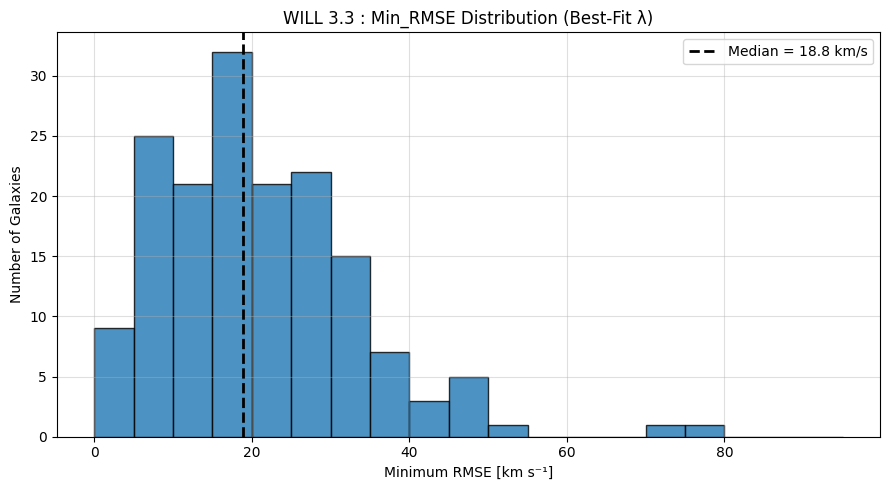

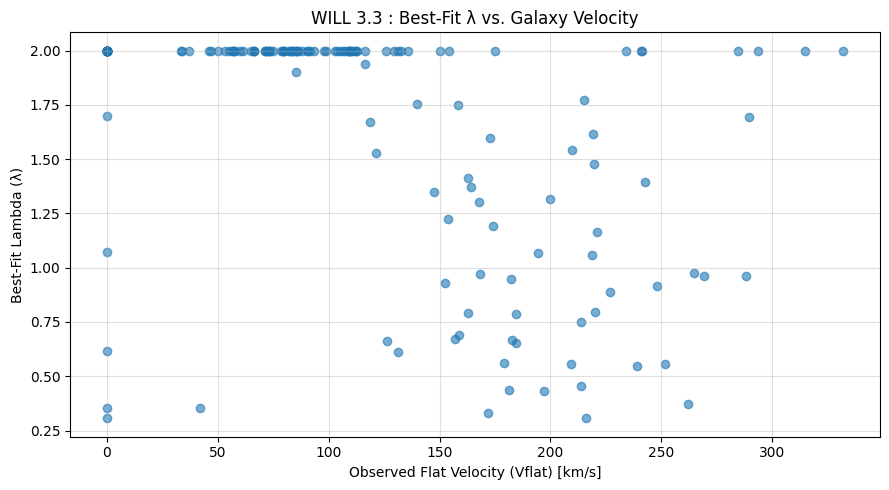

In [ ]:
# ============  WILL 3.3 : Best-Fit Lambda Model ========================
# Для каждой галактики находится оптимальное значение lambda,
# которое минимизирует отклонение (RMSE).
# =======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize_scalar
from IPython.display import display

# ---------- 1. Подготовка данных (без изменений) --------------------
DATA = '/content/DATA'
META = f'{DATA}/table1.dat'
CURV = f'{DATA}/table2.dat'

# Загрузка метаданных для Vflat и Qual
meta = pd.read_fwf(
    META,
    colspecs=[(0,11), (100,106), (112,115)],
    names=['Galaxy', 'Vflat', 'Qual']
)
meta['Vflat'] = pd.to_numeric(meta['Vflat'], errors='coerce')
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')

# Загрузка кривых вращения
curves = pd.read_table(
    CURV, sep=r'\s+', comment='#', header=None,
    usecols=[0, 2, 3, 5, 6, 7],
    names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
)
num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)


# ---------- 2. Решатель (без изменений) -------------------------------
def will_v_simplified(df, lam, y_star):
    df = df.sort_values('r').copy()
    v_bary_sq = df['Vgas']**2 + y_star * (df['Vdisk']**2 + df['Vbul']**2)
    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)
    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = lam * integral[non_zero_r] / df.loc[non_zero_r, 'r']
    v_pred_sq = v_bary_sq + geom_term
    return np.sqrt(np.clip(v_pred_sq, 0, None))


# ---------- 3. Основной цикл с оптимизацией ----------------------------
Y_STAR = 0.5
results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name]
    if len(gdf) < 3: continue

    # Функция, которую мы будем минимизировать. Она возвращает RMSE для данного lambda.
    def objective_rmse(lam, galaxy_df, y_star_val):
        v_pred = will_v_simplified(galaxy_df, lam=lam, y_star=y_star_val)
        # Убедимся, что сравниваем с отсортированными Vobs
        v_obs_sorted = galaxy_df.sort_values('r')['Vobs']
        return np.sqrt(np.mean((v_obs_sorted - v_pred)**2))

    # Запускаем оптимизатор для поиска лучшего lambda в диапазоне [0, 2]
    opt_result = minimize_scalar(
        objective_rmse,
        bounds=(0, 2.0),
        args=(gdf, Y_STAR),
        method='bounded'
    )

    if opt_result.success:
        results.append({
            'Galaxy': galaxy_name,
            'Best_Lambda': opt_result.x,  # Оптимальное значение lambda
            'Min_RMSE': opt_result.fun     # Минимальная достигнутая ошибка
        })

# Создаем итоговый DataFrame
df_results = pd.DataFrame(results)

# Добавляем Vflat для построения графика корреляции
df_results = df_results.merge(meta[['Galaxy', 'Vflat']], on='Galaxy').set_index('Galaxy')


# ---------- 4. Вывод результатов ---------------------------------------
print("\n===== WILL 3.3 : Best-Fit Lambda Model =====")
print(f"Galaxies analysed : {len(df_results)}")
print(f"Median of Min_RMSE [km/s]: {df_results.Min_RMSE.median():.2f}\n")
display(df_results.sort_values('Min_RMSE').head(20))


# --- График 1: Распределение минимальных ошибок ---
plt.figure(figsize=(9, 5))
plt.hist(df_results.Min_RMSE, bins=np.arange(0, 100, 5), edgecolor='k', alpha=0.8)
plt.axvline(df_results.Min_RMSE.median(), ls='--', lw=2, c='k',
            label=f"Median = {df_results.Min_RMSE.median():.1f} km/s")
plt.xlabel('Minimum RMSE [km s⁻¹]')
plt.ylabel('Number of Galaxies')
plt.title('WILL 3.3 : Min_RMSE Distribution (Best-Fit λ)')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# --- График 2: Поиск корреляции ---
plt.figure(figsize=(9, 5))
plt.scatter(df_results.Vflat, df_results.Best_Lambda, alpha=0.6)
plt.xlabel('Observed Flat Velocity (Vflat) [km/s]')
plt.ylabel('Best-Fit Lambda (λ)')
plt.title('WILL 3.3 : Best-Fit λ vs. Galaxy Velocity')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


===== WILL 3.4 : Lambda Correlation Analysis =====
Galaxies analysed : 163
Median of Min_RMSE [km/s]: 18.83
Galaxies where lambda=2 is a good fit (within 5% of optimum): 109



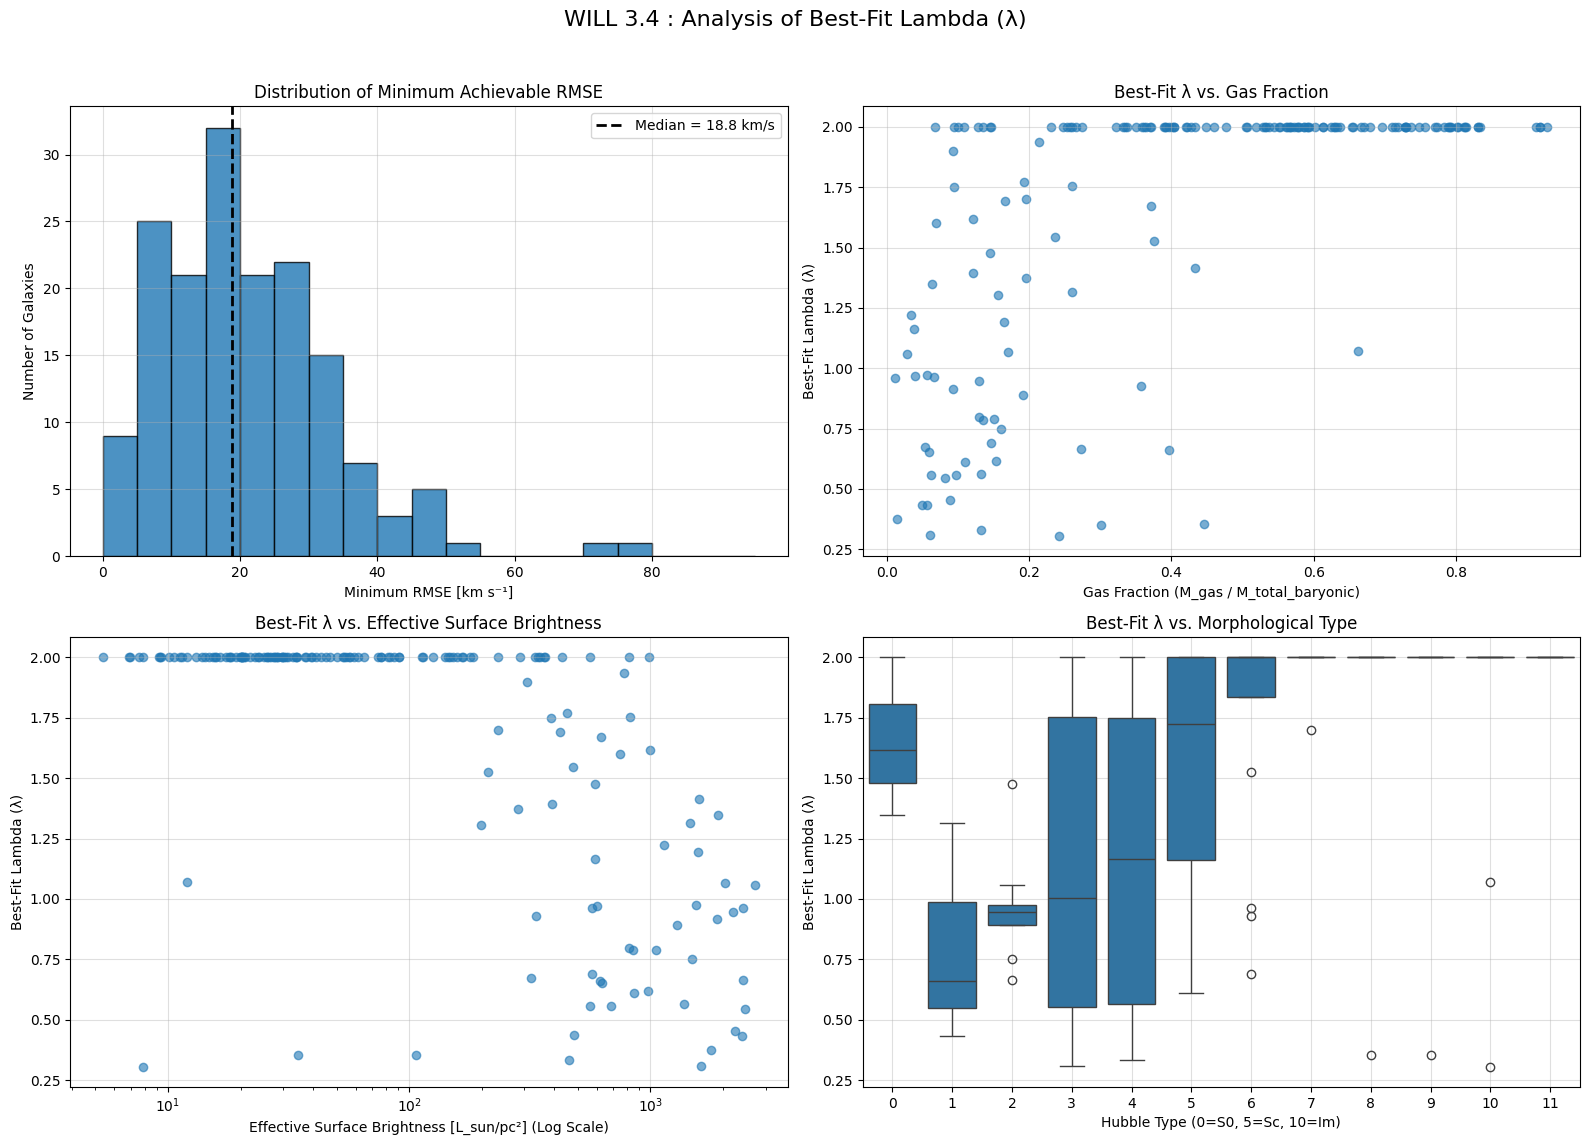

In [ ]:
# ============  WILL 3.4 : Lambda Correlation Analysis ===================
# Исследуем зависимость оптимального lambda от физических свойств галактик
# и проверяем гипотезу о lambda = 2.
# =======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize_scalar
from IPython.display import display

# ---------- 1. Подготовка данных (загружаем больше полей) --------------
DATA = '/content/DATA'
META_FILE = f'{DATA}/table1.dat'
CURV_FILE = f'{DATA}/table2.dat'

# Загружаем все необходимые метаданные
meta_colspecs = [
    (0, 11), (12, 14), (40, 47), (48, 55), (71, 76),
    (62, 70), (86, 93), (100, 106), (112, 115)
]
meta_names = [
    'Galaxy', 'Type', 'L3.6', 'e_L3.6', 'Rdisk',
    'SBeff', 'MHI', 'Vflat', 'Qual'
]
meta = pd.read_fwf(META_FILE, colspecs=meta_colspecs, names=meta_names)
for col in meta.columns:
    if col != 'Galaxy':
        meta[col] = pd.to_numeric(meta[col], errors='coerce')

# Загрузка кривых вращения (без изменений)
curves = pd.read_table(
    CURV_FILE, sep=r'\s+', comment='#', header=None,
    usecols=[0, 2, 3, 5, 6, 7],
    names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
)
num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)

# ---------- 2. Решатель и основной цикл (с доп. расчетом) -----------
Y_STAR = 0.5

def will_v_simplified(df, lam, y_star):
    df = df.sort_values('r').copy()
    v_bary_sq = df['Vgas']**2 + y_star * (df['Vdisk']**2 + df['Vbul']**2)
    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)
    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = lam * integral[non_zero_r] / df.loc[non_zero_r, 'r']
    return np.sqrt(np.clip(v_bary_sq + geom_term, 0, None))

results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name]
    if len(gdf) < 3: continue

    def objective_rmse(lam, galaxy_df, y_star_val):
        v_pred = will_v_simplified(galaxy_df, lam=lam, y_star=y_star_val)
        return np.sqrt(np.mean((galaxy_df.sort_values('r')['Vobs'] - v_pred)**2))

    opt_result = minimize_scalar(objective_rmse, bounds=(0, 2.0), args=(gdf, Y_STAR), method='bounded')

    if opt_result.success:
        v_pred_at_2 = will_v_simplified(gdf, lam=2.0, y_star=Y_STAR)
        rmse_at_2 = np.sqrt(np.mean((gdf.sort_values('r')['Vobs'] - v_pred_at_2)**2))
        results.append({
            'Galaxy': galaxy_name,
            'Best_Lambda': opt_result.x,
            'Min_RMSE': opt_result.fun,
            'RMSE_at_Lambda_2': rmse_at_2
        })

# --- Создание и обогащение итоговой таблицы ---
df_results = pd.DataFrame(results)
df_results = df_results.merge(meta, on='Galaxy', how='left')

# Расчет газовой фракции
df_results['M_stars'] = df_results['L3.6'] * Y_STAR
df_results['f_gas'] = df_results['MHI'] / (df_results['MHI'] + df_results['M_stars'])

# Проверка гипотезы lambda=2
df_results['Lambda_2_is_good_fit'] = (df_results['RMSE_at_Lambda_2'] / df_results['Min_RMSE']) < 1.05

# ---------- 3. Вывод результатов и графиков -----------------------------
num_lambda_2_galaxies = df_results[df_results['Lambda_2_is_good_fit']].shape[0]

print("\n===== WILL 3.4 : Lambda Correlation Analysis =====")
print(f"Galaxies analysed : {len(df_results)}")
print(f"Median of Min_RMSE [km/s]: {df_results.Min_RMSE.median():.2f}")
print(f"Galaxies where lambda=2 is a good fit (within 5% of optimum): {num_lambda_2_galaxies}\n")

# --- Графики для анализа ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('WILL 3.4 : Analysis of Best-Fit Lambda (λ)', fontsize=16)

# График 1: Распределение Min_RMSE
axes[0, 0].hist(df_results.Min_RMSE.dropna(), bins=np.arange(0, 100, 5), edgecolor='k', alpha=0.8)
axes[0, 0].axvline(df_results.Min_RMSE.median(), ls='--', lw=2, c='k', label=f"Median = {df_results.Min_RMSE.median():.1f} km/s")
axes[0, 0].set_title('Distribution of Minimum Achievable RMSE')
axes[0, 0].set_xlabel('Minimum RMSE [km s⁻¹]')
axes[0, 0].set_ylabel('Number of Galaxies')
axes[0, 0].legend()

# График 2: λ vs Газовая фракция
axes[0, 1].scatter(df_results['f_gas'], df_results['Best_Lambda'], alpha=0.6)
axes[0, 1].set_title('Best-Fit λ vs. Gas Fraction')
axes[0, 1].set_xlabel('Gas Fraction (M_gas / M_total_baryonic)')
axes[0, 1].set_ylabel('Best-Fit Lambda (λ)')

# График 3: λ vs Поверхностная яркость
axes[1, 0].scatter(df_results['SBeff'], df_results['Best_Lambda'], alpha=0.6)
axes[1, 0].set_title('Best-Fit λ vs. Effective Surface Brightness')
axes[1, 0].set_xlabel('Effective Surface Brightness [L_sun/pc²] (Log Scale)')
axes[1, 0].set_ylabel('Best-Fit Lambda (λ)')
axes[1, 0].set_xscale('log')

# График 4: λ vs Морфологический тип
sns.boxplot(ax=axes[1, 1], x='Type', y='Best_Lambda', data=df_results.sort_values('Type'))
axes[1, 1].set_title('Best-Fit λ vs. Morphological Type')
axes[1, 1].set_xlabel('Hubble Type (0=S0, 5=Sc, 10=Im)')
axes[1, 1].set_ylabel('Best-Fit Lambda (λ)')

for ax in axes.flat:
    ax.grid(True, alpha=0.4)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


===== WILL 4.0 : Unified Parameter Model (Y* = 1/λ) =====
Galaxies analysed : 163
Median of Min_RMSE [km/s]: 12.89



,Best_Lambda,Implied_Y_star,Min_RMSE,Vflat
Galaxy,,,,
D512-2,0.443008,2.257297,1.061109,0.0
UGC07690,1.106209,0.903989,1.365056,57.4
UGC05918,0.202201,4.945576,1.434823,0.0
UGC07866,0.611329,1.635782,1.478247,0.0
UGC10310,0.459713,2.175272,1.521626,71.4
UGC07577,3.208756,0.311647,1.546382,0.0
KK98-251,3.999995,0.250000,1.654821,33.7
UGC04483,3.999995,0.250000,1.922363,0.0
UGC07151,0.918370,1.088886,2.025547,73.5


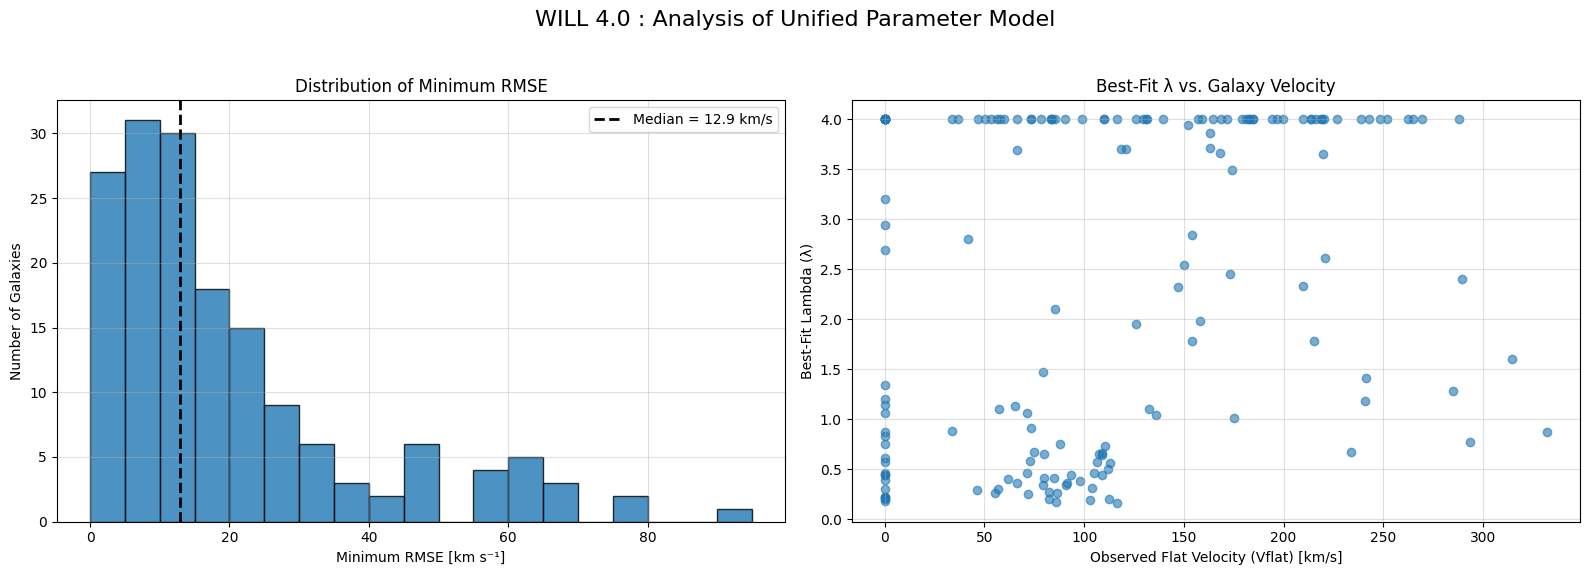

from matplotlib import pyplot as plt
_df_0['Best_Lambda'].plot(kind='hist', bins=20, title='Best_Lambda')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Implied_Y_star'].plot(kind='hist', bins=20, title='Implied_Y_star')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Min_RMSE'].plot(kind='hist', bins=20, title='Min_RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Vflat'].plot(kind='hist', bins=20, title='Vflat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Best_Lambda', y='Implied_Y_star', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Implied_Y_star', y='Min_RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Min_RMSE', y='Vflat', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Min_RMSE']
  ys = series['Best_Lambda']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Min_RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Min_RMSE')
_ = plt.ylabel('Best_Lambda')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Min_RMSE']
  ys = series['Implied_Y_star']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Min_RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Min_RMSE')
_ = plt.ylabel('Implied_Y_star')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Min_RMSE']
  ys = series['Vflat']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Min_RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Min_RMSE')
_ = plt.ylabel('Vflat')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Min_RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Min_RMSE'}, axis=1)
              .sort_values('Min_RMSE', ascending=True))
  xs = counted['Min_RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Min_RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Min_RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['Best_Lambda'].plot(kind='line', figsize=(8, 4), title='Best_Lambda')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Implied_Y_star'].plot(kind='line', figsize=(8, 4), title='Implied_Y_star')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Min_RMSE'].plot(kind='line', figsize=(8, 4), title='Min_RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Vflat'].plot(kind='line', figsize=(8, 4), title='Vflat')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# ============  WILL 4.0 : Unified Parameter Model (Y* = 1/λ) ==============
# Проверяем гипотезу о том, что Y_star и lambda взаимосвязаны,
# оставляя в модели только один свободный параметр - lambda.
# =========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize_scalar
from IPython.display import display

# ---------- 1. Подготовка данных (без изменений) --------------------
DATA = '/content/DATA'
META_FILE = f'{DATA}/table1.dat'
CURV_FILE = f'{DATA}/table2.dat'

# Загрузка метаданных
meta = pd.read_fwf(
    META_FILE,
    colspecs=[(0,11), (100,106), (112,115)],
    names=['Galaxy', 'Vflat', 'Qual']
)
meta['Vflat'] = pd.to_numeric(meta['Vflat'], errors='coerce')
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')

# Загрузка кривых вращения
curves = pd.read_table(
    CURV_FILE, sep=r'\s+', comment='#', header=None,
    usecols=[0, 2, 3, 5, 6, 7],
    names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
)
num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)


# ---------- 2. Новый единый решатель -----------------------------------
def will_v_unified(df, lam):
    """
    Рассчитывает скорость, используя только один параметр lambda,
    где y_star = 1/lambda.
    """
    # Предотвращаем деление на ноль, если оптимизатор пробует lam=0
    if lam == 0:
        lam = 1e-9

    df = df.sort_values('r').copy()
    y_star = 1.0 / lam  # Ключевая гипотеза

    v_stars_sq = df['Vdisk']**2 + df['Vbul']**2
    v_bary_sq = df['Vgas']**2 + y_star * v_stars_sq

    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)

    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = lam * integral[non_zero_r] / df.loc[non_zero_r, 'r']

    v_pred_sq = v_bary_sq + geom_term
    return np.sqrt(np.clip(v_pred_sq, 0, None))


# ---------- 3. Основной цикл с оптимизацией ----------------------------
results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name]
    if len(gdf) < 3: continue

    def objective_rmse(lam, galaxy_df):
        v_pred = will_v_unified(galaxy_df, lam=lam)
        return np.sqrt(np.mean((galaxy_df.sort_values('r')['Vobs'] - v_pred)**2))

    opt_result = minimize_scalar(
        objective_rmse,
        bounds=(0.1, 4.0),  # Расширим границы поиска
        args=(gdf,),
        method='bounded'
    )

    if opt_result.success:
        best_lambda = opt_result.x
        results.append({
            'Galaxy': galaxy_name,
            'Best_Lambda': best_lambda,
            'Implied_Y_star': 1.0 / best_lambda,
            'Min_RMSE': opt_result.fun
        })

# --- Создание итоговой таблицы ---
df_results = pd.DataFrame(results)
df_results = df_results.merge(meta[['Galaxy', 'Vflat']], on='Galaxy', how='left').set_index('Galaxy')


# ---------- 4. Вывод результатов и графиков -----------------------------
print("\n===== WILL 4.0 : Unified Parameter Model (Y* = 1/λ) =====")
print(f"Galaxies analysed : {len(df_results)}")
print(f"Median of Min_RMSE [km/s]: {df_results.Min_RMSE.median():.2f}\n")
display(df_results.sort_values('Min_RMSE').head(20))

# --- Графики для анализа ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('WILL 4.0 : Analysis of Unified Parameter Model', fontsize=16)

# График 1: Распределение Min_RMSE
axes[0].hist(df_results.Min_RMSE.dropna(), bins=np.arange(0, 100, 5), edgecolor='k', alpha=0.8)
axes[0].axvline(df_results.Min_RMSE.median(), ls='--', lw=2, c='k', label=f"Median = {df_results.Min_RMSE.median():.1f} km/s")
axes[0].set_title('Distribution of Minimum RMSE')
axes[0].set_xlabel('Minimum RMSE [km s⁻¹]')
axes[0].set_ylabel('Number of Galaxies')
axes[0].legend()

# График 2: Зависимость Best_Lambda от Vflat
axes[1].scatter(df_results['Vflat'], df_results['Best_Lambda'], alpha=0.6)
axes[1].set_title('Best-Fit λ vs. Galaxy Velocity')
axes[1].set_xlabel('Observed Flat Velocity (Vflat) [km/s]')
axes[1].set_ylabel('Best-Fit Lambda (λ)')

for ax in axes.flat:
    ax.grid(True, alpha=0.4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

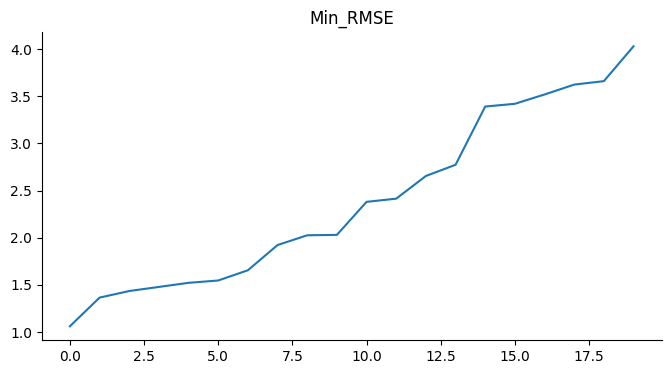

In [ ]:
from matplotlib import pyplot as plt
_df_13['Min_RMSE'].plot(kind='line', figsize=(8, 4), title='Min_RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

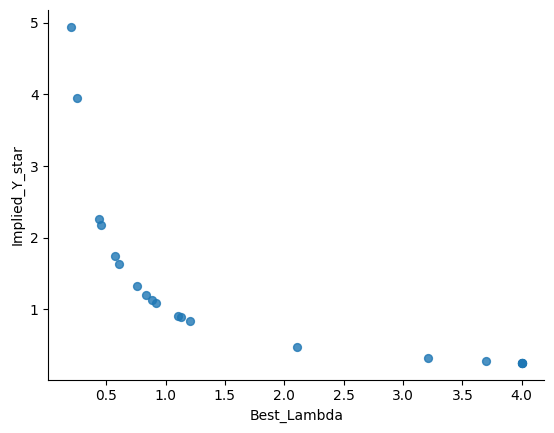

In [ ]:
from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Best_Lambda', y='Implied_Y_star', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

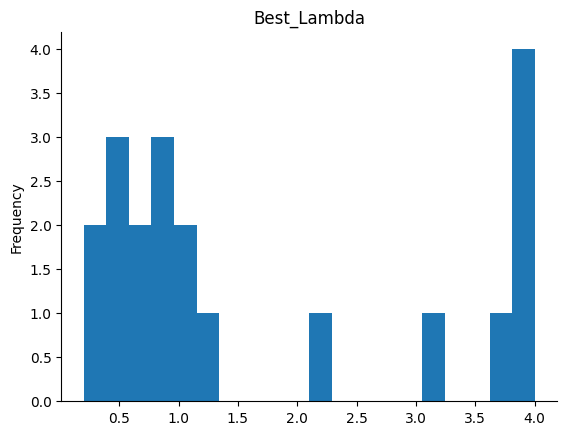

In [ ]:
from matplotlib import pyplot as plt
_df_0['Best_Lambda'].plot(kind='hist', bins=20, title='Best_Lambda')
plt.gca().spines[['top', 'right',]].set_visible(False)


===== WILL 5.0 : Parameter-Free Model (Y*=1, λ=1) =====
Galaxies analysed : 163
Median RMSE [km/s]: 24.62



,RMSE
Galaxy,
UGC07690,1.989042
UGC07151,2.459515
UGC07559,2.782431
UGC07125,2.930353
UGC07866,3.385618
UGC07577,3.448166
UGC09992,3.560620
UGC04483,3.752276
NGC4068,4.098127


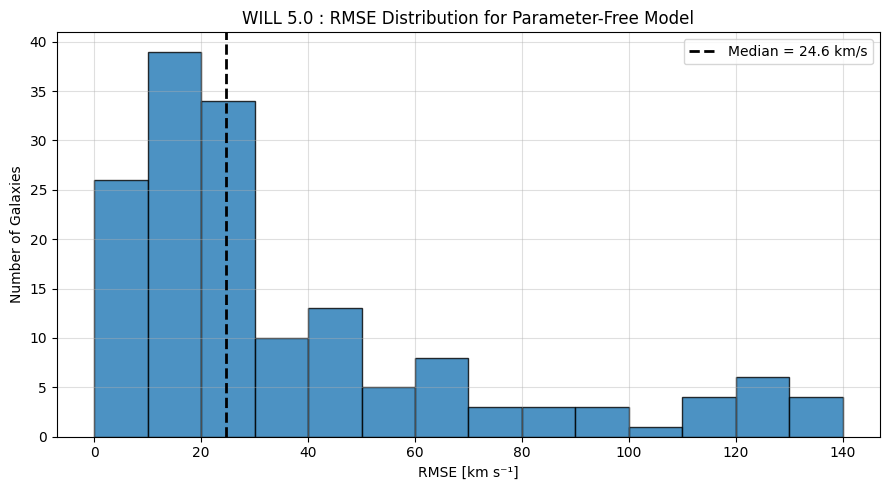

In [ ]:
# ============  WILL 5.0 : Parameter-Free Model (Y*=1, λ=1) ===============
# Проверяем "чистую" модель без свободных параметров.
# Y_star и lambda принудительно установлены в 1.0.
# ========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from IPython.display import display

# ---------- 1. Подготовка данных (без изменений) --------------------
DATA = '/content/DATA'
META_FILE = f'{DATA}/table1.dat'
CURV_FILE = f'{DATA}/table2.dat'

# Загрузка метаданных
meta = pd.read_fwf(
    META_FILE,
    colspecs=[(0,11), (112,115)],
    names=['Galaxy', 'Qual']
)
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')

# Загрузка кривых вращения
curves = pd.read_table(
    CURV_FILE, sep=r'\s+', comment='#', header=None,
    usecols=[0, 2, 3, 5, 6, 7],
    names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
)
num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)


# ---------- 2. Решатель без параметров -----------------------------------
def will_v_parameter_free(df):
    """
    Рассчитывает скорость по формуле, где Y_star=1 и lambda=1.
    """
    df = df.sort_values('r').copy()

    # Y_star = 1.0
    v_bary_sq = df['Vgas']**2 + (df['Vdisk']**2 + df['Vbul']**2)

    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)

    # lambda = 1.0
    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = integral[non_zero_r] / df.loc[non_zero_r, 'r']

    v_pred_sq = v_bary_sq + geom_term
    return np.sqrt(np.clip(v_pred_sq, 0, None))


# ---------- 3. Основной цикл (без оптимизации) ------------------------
results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name]
    if len(gdf) < 3:
        continue

    v_predicted = will_v_parameter_free(gdf)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - v_predicted)**2))

    if np.isfinite(rmse):
        results.append({'Galaxy': galaxy_name, 'RMSE': rmse})

# Создаем итоговый DataFrame
df_results = pd.DataFrame(results).set_index('Galaxy').sort_values('RMSE')


# ---------- 4. Вывод результатов ---------------------------------------
print("\n===== WILL 5.0 : Parameter-Free Model (Y*=1, λ=1) =====")
print(f"Galaxies analysed : {len(df_results)}")
print(f"Median RMSE [km/s]: {df_results.RMSE.median():.2f}\n")
display(df_results.head(20))

plt.figure(figsize=(9, 5))
plt.hist(df_results.RMSE, bins=np.arange(0, 150, 10), edgecolor='k', alpha=0.8)
plt.axvline(df_results.RMSE.median(), ls='--', lw=2, c='k',
            label=f"Median = {df_results.RMSE.median():.1f} km/s")
plt.xlabel('RMSE [km s⁻¹]')
plt.ylabel('Number of Galaxies')
plt.title('WILL 5.0 : RMSE Distribution for Parameter-Free Model')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


===== WILL 5.1 : Parameter-Free Model (Qual=1 only) =====
Galaxies analysed : 99
Median RMSE [km/s]: 26.35



,RMSE
Galaxy,
UGC07151,2.459515
UGC07125,2.930353
UGC05414,4.597726
UGC07323,5.007926
NGC3917,5.351623
NGC3972,5.522201
F583-4,9.293881
NGC4183,9.477788
UGC04499,9.942636


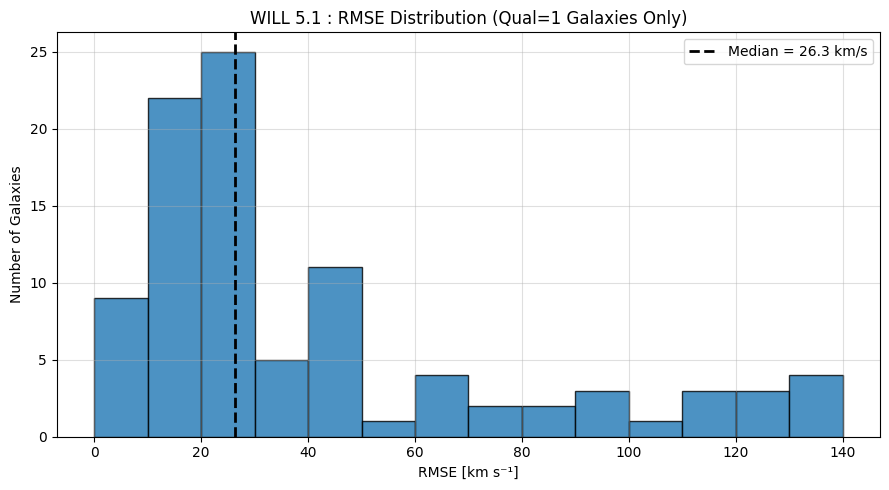

In [ ]:
# ============  WILL 5.1 : Parameter-Free Model on Qual=1 Data ===========
# Проверяем "чистую" модель на самом качественном подмножестве данных.
# Y_star = 1.0, lambda = 1.0.
# ========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from IPython.display import display

# ---------- 1. Подготовка данных ----------------------------------------
DATA = '/content/DATA'
META_FILE = f'{DATA}/table1.dat'
CURV_FILE = f'{DATA}/table2.dat'

# Загрузка метаданных
meta = pd.read_fwf(
    META_FILE,
    colspecs=[(0,11), (112,115)],
    names=['Galaxy', 'Qual']
)
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')

# Загрузка кривых вращения
curves = pd.read_table(
    CURV_FILE, sep=r'\s+', comment='#', header=None,
    usecols=[0, 2, 3, 5, 6, 7],
    names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
)
num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)


# ---------- 2. Решатель без параметров (без изменений) ------------------
def will_v_parameter_free(df):
    df = df.sort_values('r').copy()
    v_bary_sq = df['Vgas']**2 + (df['Vdisk']**2 + df['Vbul']**2)
    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)
    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = integral[non_zero_r] / df.loc[non_zero_r, 'r']
    v_pred_sq = v_bary_sq + geom_term
    return np.sqrt(np.clip(v_pred_sq, 0, None))


# ---------- 3. Основной цикл (только Qual=1) ---------------------------
results = []
# --- ГЛАВНОЕ ИЗМЕНЕНИЕ ЗДЕСЬ ---
galaxies_to_run = meta[meta['Qual'] == 1]['Galaxy'].unique()

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name]
    if len(gdf) < 3: continue

    v_predicted = will_v_parameter_free(gdf)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - v_predicted)**2))

    if np.isfinite(rmse):
        results.append({'Galaxy': galaxy_name, 'RMSE': rmse})

df_results = pd.DataFrame(results).set_index('Galaxy').sort_values('RMSE')

# ---------- 4. Вывод результатов ---------------------------------------
print("\n===== WILL 5.1 : Parameter-Free Model (Qual=1 only) =====")
print(f"Galaxies analysed : {len(df_results)}")
print(f"Median RMSE [km/s]: {df_results.RMSE.median():.2f}\n")
display(df_results.head(20))

plt.figure(figsize=(9, 5))
plt.hist(df_results.RMSE, bins=np.arange(0, 150, 10), edgecolor='k', alpha=0.8)
plt.axvline(df_results.RMSE.median(), ls='--', lw=2, c='k',
            label=f"Median = {df_results.RMSE.median():.1f} km/s")
plt.xlabel('RMSE [km s⁻¹]')
plt.ylabel('Number of Galaxies')
plt.title('WILL 5.1 : RMSE Distribution (Qual=1 Galaxies Only)')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 163, number of used features: 5
[LightGBM] [Info] Start training from score 2.381036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

,feature,importance
4,L3.6,144
2,SBeff,141
1,f_gas,125
0,Vflat,94
3,Type,38


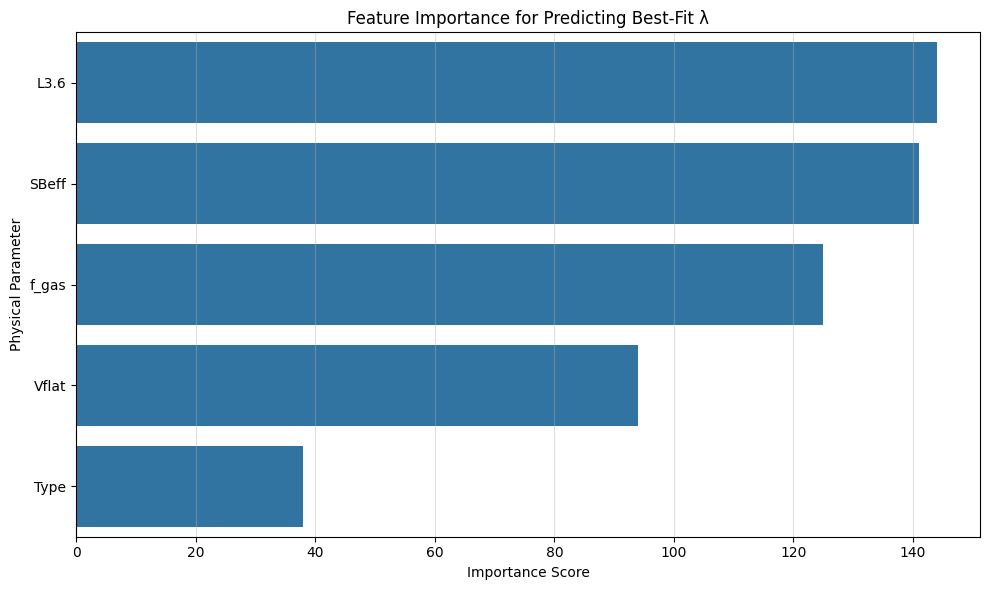

In [ ]:
# ============  WILL 6.0 : Lambda Discovery via Machine Learning ============
# Используем модель градиентного бустинга для поиска физического закона,
# управляющего параметром lambda.
# ==========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize_scalar
from IPython.display import display
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# ---------- 1. Подготовка данных (идентична WILL 3.4) --------------------
# ... (Этот блок кода идентичен коду из WILL 3.4 для загрузки и подготовки данных)
# --- Начало блока подготовки данных ---
DATA = '/content/DATA'
META_FILE = f'{DATA}/table1.dat'
CURV_FILE = f'{DATA}/table2.dat'
meta_colspecs = [(0,11),(12,14),(40,47),(62,70),(86,93),(100,106),(112,115)]
meta_names = ['Galaxy','Type','L3.6','SBeff','MHI','Vflat','Qual']
meta = pd.read_fwf(META_FILE, colspecs=meta_colspecs, names=meta_names)
for col in meta.columns:
    if col not in ['Galaxy', 'Type']:
        meta[col] = pd.to_numeric(meta[col], errors='coerce')
curves = pd.read_table(CURV_FILE, sep=r'\s+', comment='#', header=None, usecols=[0,2,3,5,6,7], names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul'])
num_cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)
# --- Конец блока подготовки данных ---

# ---------- 2. Расчет Best_Lambda (идентично WILL 4.0) ----------------
# ... (Этот блок кода идентичен коду из WILL 4.0 для нахождения Best_Lambda)
# --- Начало блока расчета Best_Lambda ---
results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()
def will_v_unified(df, lam):
    if lam == 0: lam = 1e-9
    df, y_star = df.sort_values('r').copy(), 1.0/lam
    v_stars_sq = df['Vdisk']**2 + df['Vbul']**2
    v_bary_sq = df['Vgas']**2 + y_star * v_stars_sq
    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)
    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = lam * integral[non_zero_r] / df.loc[non_zero_r, 'r']
    return np.sqrt(np.clip(v_bary_sq + geom_term, 0, None))

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name]
    if len(gdf) < 3: continue
    def objective_rmse(lam, galaxy_df):
        v_pred = will_v_unified(galaxy_df, lam=lam)
        return np.sqrt(np.mean((galaxy_df.sort_values('r')['Vobs'] - v_pred)**2))
    opt_result = minimize_scalar(objective_rmse, bounds=(0.1, 4.0), args=(gdf,), method='bounded')
    if opt_result.success:
        results.append({'Galaxy': galaxy_name, 'Best_Lambda': opt_result.x})
df_lambda = pd.DataFrame(results)
# --- Конец блока расчета Best_Lambda ---


# ---------- 3. Создание датасета для машинного обучения ----------------
# Объединяем результаты с метаданными
ml_df = df_lambda.merge(meta, on='Galaxy', how='left')

# Рассчитываем газовую фракцию
ml_df['M_stars'] = ml_df['L3.6'] * 0.5 # Используем Y_star=0.5 для оценки барионного состава
ml_df['f_gas'] = ml_df['MHI'] / (ml_df['MHI'] + ml_df['M_stars'])

# Выбираем признаки и цель, удаляем строки с пропущенными значениями
features = ['Vflat', 'f_gas', 'SBeff', 'Type', 'L3.6']
target = 'Best_Lambda'
ml_df = ml_df[features + [target]].dropna()

X = ml_df[features]
y = ml_df[target]

# ---------- 4. Обучение модели и оценка важности признаков -------------
# Настраиваем и обучаем модель LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X, y)

# Получаем важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)


# ---------- 5. Вывод результатов ---------------------------------------
print("\n===== WILL 6.0 : Lambda Discovery Results =====")
print("Модель машинного обучения попыталась найти закон, управляющий lambda.")
print("Важность каждого физического параметра в предсказании lambda:\n")
display(feature_importance)

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Predicting Best-Fit λ')
plt.xlabel('Importance Score')
plt.ylabel('Physical Parameter')
plt.grid(alpha=0.4, axis='x')
plt.tight_layout()
plt.show()


===== WILL 7.0 : Testing λ = f(κ²) Hypothesis =====
Galaxies with valid Vflat analysed: 129
Pearson Correlation between Best_Lambda and kappa_flat_sq: 0.2357



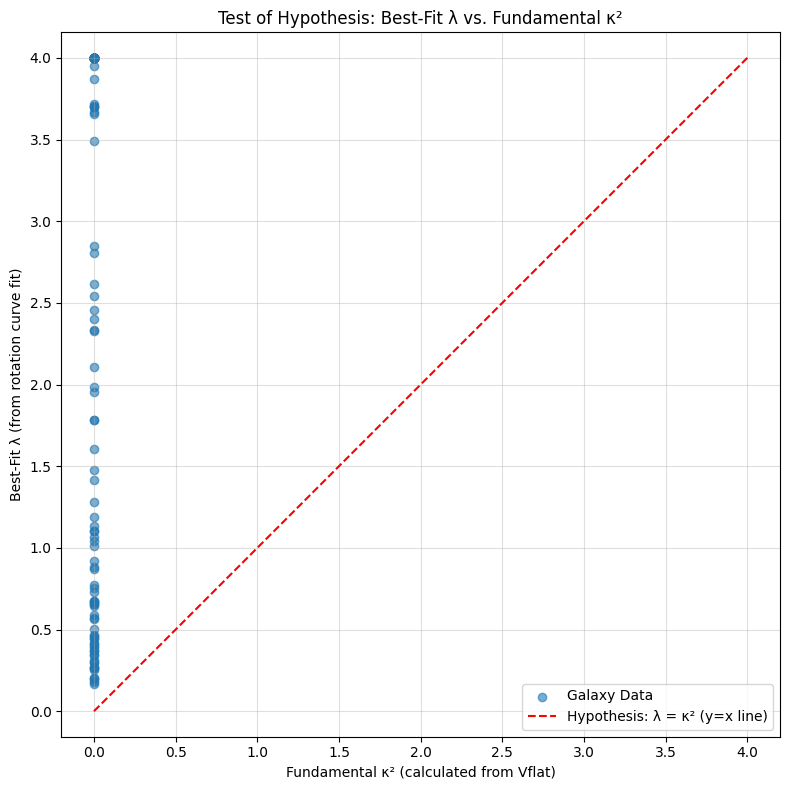

In [ ]:
# ============  WILL 7.0 : Testing the λ = f(κ²) Hypothesis ===============
# Сравниваем оптимальное значение lambda из модели 4.0
# с фундаментальным параметром κ², вычисленным из V_flat.
# ========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize_scalar
from IPython.display import display

# ---------- 1. Подготовка данных и расчет Best_Lambda (из WILL 4.0) ------
# ... (Этот блок кода идентичен коду из WILL 4.0 для загрузки данных и нахождения Best_Lambda)
# --- Начало блока ---
DATA = '/content/DATA'
META_FILE = f'{DATA}/table1.dat'
CURV_FILE = f'{DATA}/table2.dat'
meta = pd.read_fwf(META_FILE, colspecs=[(0,11), (100,106), (112,115)], names=['Galaxy', 'Vflat', 'Qual'])
meta['Vflat'] = pd.to_numeric(meta['Vflat'], errors='coerce')
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')
curves = pd.read_table(CURV_FILE, sep=r'\s+', comment='#', header=None, usecols=[0,2,3,5,6,7], names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul'])
num_cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)
results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()
def will_v_unified(df, lam):
    if lam == 0: lam = 1e-9
    df, y_star = df.sort_values('r').copy(), 1.0/lam
    v_stars_sq = df['Vdisk']**2 + df['Vbul']**2
    v_bary_sq = df['Vgas']**2 + y_star * v_stars_sq
    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)
    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = lam * integral[non_zero_r] / df.loc[non_zero_r, 'r']
    return np.sqrt(np.clip(v_bary_sq + geom_term, 0, None))
for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name]
    if len(gdf) < 3: continue
    def objective_rmse(lam, galaxy_df):
        v_pred = will_v_unified(galaxy_df, lam=lam)
        return np.sqrt(np.mean((galaxy_df.sort_values('r')['Vobs'] - v_pred)**2))
    opt_result = minimize_scalar(objective_rmse, bounds=(0.1, 4.0), args=(gdf,), method='bounded')
    if opt_result.success:
        results.append({'Galaxy': galaxy_name, 'Best_Lambda': opt_result.x})
df_results = pd.DataFrame(results)
# --- Конец блока ---


# ---------- 2. Расчет kappa^2 и подготовка к анализу --------------------
# Объединяем результаты с Vflat и отбрасываем галактики без Vflat
df_final = df_results.merge(meta[['Galaxy', 'Vflat']], on='Galaxy', how='left')
df_final = df_final[df_final['Vflat'] > 0].dropna()

# Скорость света в км/с
c_kms = 299792.458

# Рассчитываем kappa_squared
df_final['beta_flat_sq'] = (df_final['Vflat'] / c_kms)**2
df_final['kappa_flat_sq'] = 2 * df_final['beta_flat_sq']


# ---------- 3. Вывод результатов и графика -----------------------------
# Рассчитываем корреляцию для оценки силы линейной связи
correlation = df_final['kappa_flat_sq'].corr(df_final['Best_Lambda'])

print("\n===== WILL 7.0 : Testing λ = f(κ²) Hypothesis =====")
print(f"Galaxies with valid Vflat analysed: {len(df_final)}")
print(f"Pearson Correlation between Best_Lambda and kappa_flat_sq: {correlation:.4f}\n")

# Строим график для визуальной проверки
plt.figure(figsize=(8, 8))
plt.scatter(df_final['kappa_flat_sq'], df_final['Best_Lambda'], alpha=0.6, label='Galaxy Data')

# Добавляем идеальную линию y=x для проверки гипотезы λ = κ²
max_val = max(df_final['kappa_flat_sq'].max(), df_final['Best_Lambda'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Hypothesis: λ = κ² (y=x line)')

plt.title('Test of Hypothesis: Best-Fit λ vs. Fundamental κ²')
plt.xlabel('Fundamental κ² (calculated from Vflat)')
plt.ylabel('Best-Fit λ (from rotation curve fit)')
plt.legend()
plt.grid(True, alpha=0.4)
plt.axis('equal') # Делаем оси равными для наглядности линии y=x
plt.tight_layout()
plt.show()

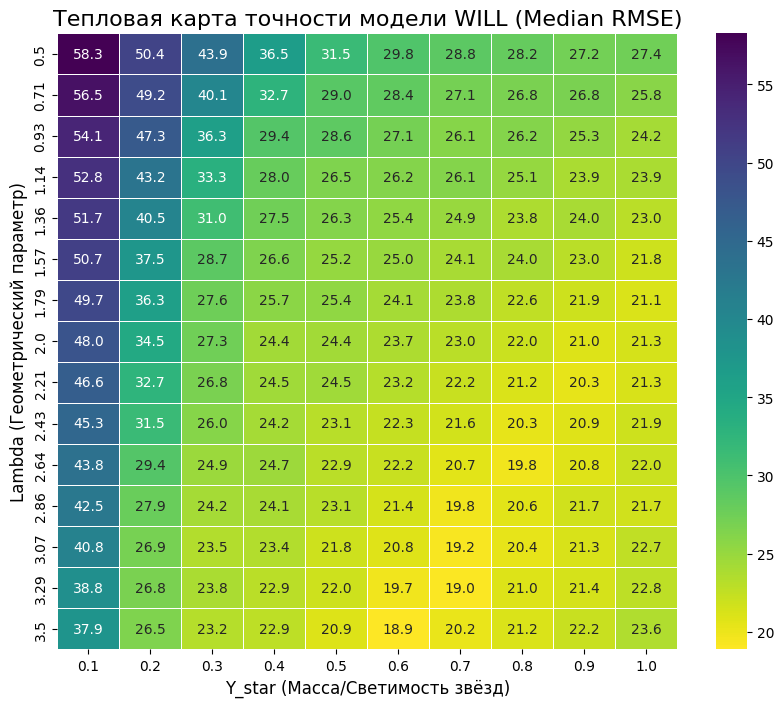

In [ ]:
# ============  WILL 8.0 : λ-Y* Accuracy Heatmap =========================
# Создаем 2D-карту точности модели (Median RMSE) в зависимости
# от параметров lambda и Y_star.
# ========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
from IPython.display import display

# --- Блок подготовки данных (идентичен предыдущим скриптам) ---
DATA = '/content/DATA'
META_FILE = f'{DATA}/table1.dat'
CURV_FILE = f'{DATA}/table2.dat'
meta = pd.read_fwf(META_FILE, colspecs=[(0,11), (112,115)], names=['Galaxy', 'Qual'])
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')
curves = pd.read_table(CURV_FILE, sep=r'\s+', comment='#', header=None, usecols=[0,2,3,5,6,7], names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul'])
num_cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)
# --- Конец блока ---

# --- Решатель (без изменений) ---
def will_v_simplified(df, lam, y_star):
    df = df.sort_values('r').copy()
    v_bary_sq = df['Vgas']**2 + y_star * (df['Vdisk']**2 + df['Vbul']**2)
    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)
    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = lam * integral[non_zero_r] / df.loc[non_zero_r, 'r']
    return np.sqrt(np.clip(v_bary_sq + geom_term, 0, None))

# --- Основной цикл для построения карты ---
# Определяем сетку параметров для проверки
lambda_range = np.linspace(0.5, 3.5, 15)
y_star_range = np.linspace(0.1, 1.0, 10)

# Создаем пустую матрицу для хранения результатов RMSE
rmse_matrix = np.zeros((len(lambda_range), len(y_star_range)))

galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()

# Запускаем расчет для каждой ячейки сетки
for i, lam_val in enumerate(lambda_range):
    for j, y_star_val in enumerate(y_star_range):
        all_rmses = []
        for galaxy_name in galaxies_to_run:
            gdf = curves[curves['Galaxy'] == galaxy_name]
            if len(gdf) < 3: continue

            v_predicted = will_v_simplified(gdf, lam=lam_val, y_star=y_star_val)
            rmse = np.sqrt(np.mean((gdf['Vobs'] - v_predicted)**2))
            if np.isfinite(rmse):
                all_rmses.append(rmse)

        # Записываем медианную ошибку для данной пары (λ, Υ*)
        if all_rmses:
            rmse_matrix[i, j] = np.median(all_rmses)

# --- Визуализация: Тепловая карта ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.DataFrame(rmse_matrix, index=np.round(lambda_range, 2), columns=np.round(y_star_range, 2)),
    annot=True, fmt=".1f", cmap="viridis_r", # _r инвертирует палитру, делая низкие значения темными
    linewidths=.5
)
plt.title('Тепловая карта точности модели WILL (Median RMSE)', fontsize=16)
plt.xlabel('Y_star (Масса/Светимость звёзд)', fontsize=12)
plt.ylabel('Lambda (Геометрический параметр)', fontsize=12)
plt.show()

Шаг 1: Загрузка данных...
Данные успешно загружены.

Шаг 2: Начинаем оптимизацию λ_stars для 163 галактик...
  Обработано 20/163...
  Обработано 40/163...
  Обработано 60/163...
  Обработано 80/163...
  Обработано 100/163...
  Обработано 120/163...
  Обработано 140/163...
  Обработано 160/163...
Оптимизация завершена.

Шаг 3: Поиск аппроксимирующей функции...

     ИТОГИ АНАЛИЗА WILL 6.0
Проанализировано галактик: 163
Медиана минимальной ошибки (RMSE): 16.44 км/с

Найдена аппроксимирующая функция для λ_stars:
  λ_stars ≈ 13.07 / SBeff + 0.76


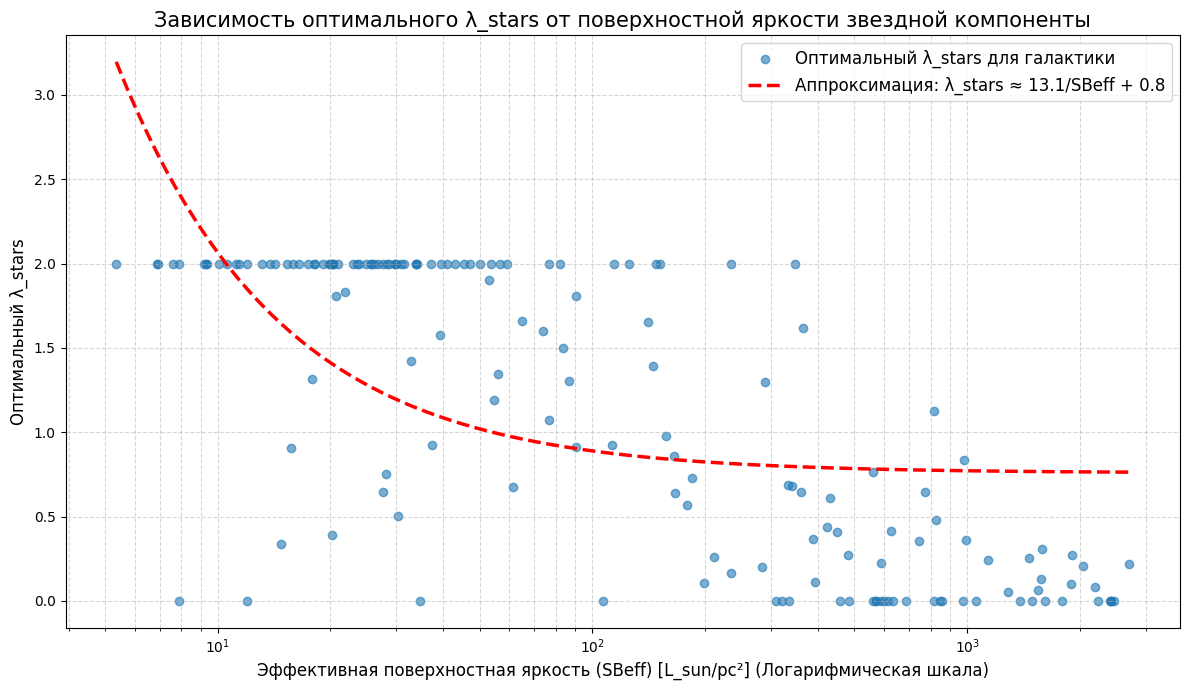


--- Топ 20 галактик по точности новой модели ---
  Galaxy  Best_Lambda_Stars  Min_RMSE  SBeff
UGC07690           0.725860  0.874474 184.01
UGC07866           1.832981  1.327958  21.92
UGC04483           1.999996  1.462934  29.71
UGC07151           1.070077  1.653710  76.71
UGC07559           1.315841  1.885216  17.90
UGC06917           1.900123  1.961134  53.07
KK98-251           1.999996  2.037635   7.89
UGC07577           0.000004  2.058547  11.94
UGC05414           1.423908  2.157693  32.87
UGC04499           1.999996  2.288676  33.79
UGC07125           0.753272  2.523856  28.11
UGC06930           1.598178  2.929995  73.93
  F583-4           1.999996  2.947144  24.94
UGC09992           0.392785  3.398569  20.18
 NGC4068           0.502907  3.566208  30.26
UGC07323           0.673749  3.686449  61.49
UGC08837           0.904852  3.847642  15.73
 NGC2976           0.000004  3.912565 308.20
 NGC0055           1.189174  3.985739  54.55
UGC07232           1.500858  4.004888  83.34


In [ ]:
# ======================================================================
# WILL 6.0: Анализ разделенной модели λ и поиск функции для λ_stars
# ======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize_scalar, curve_fit

def run_analysis():
    """
    Основная функция, инкапсулирующая весь анализ.
    """
    # --- Шаг 1: Загрузка и подготовка данных ---
    # Убедитесь, что ваши файлы находятся в этой директории в Colab
    DATA_PATH = '/content/DATA'
    META_FILE = f'{DATA_PATH}/table1.dat'
    CURV_FILE = f'{DATA_PATH}/table2.dat'

    print("Шаг 1: Загрузка данных...")
    try:
        # Загружаем метаданные, включая поверхностную яркость (SBeff)
        meta_colspecs = [
            (0, 11), (12, 14), (40, 47), (48, 55), (71, 76),
            (62, 70), (86, 93), (100, 106), (112, 115)
        ]
        meta_names = [
            'Galaxy', 'Type', 'L3.6', 'e_L3.6', 'Rdisk',
            'SBeff', 'MHI', 'Vflat', 'Qual'
        ]
        meta = pd.read_fwf(META_FILE, colspecs=meta_colspecs, names=meta_names)
        for col in meta.columns:
            if col != 'Galaxy':
                meta[col] = pd.to_numeric(meta[col], errors='coerce')

        # Загрузка кривых вращения
        curves = pd.read_table(
            CURV_FILE, sep=r'\s+', comment='#', header=None,
            usecols=[0, 2, 3, 5, 6, 7],
            names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        )
        num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
        curves.dropna(subset=['r', 'Vobs'], inplace=True)
        curves.fillna(0, inplace=True) # Заполняем NaN нулями, особенно для Vbul
        print("Данные успешно загружены.")
    except FileNotFoundError:
        print(f"ОШИБКА: Файлы данных не найдены по пути '{DATA_PATH}'.")
        print("Пожалуйста, убедитесь, что вы загрузили table1.dat и table2.dat в эту директорию.")
        return

    # --- Шаг 2: Реализация новой модели WILL 6.0 ---
    def will_v_split_lambda(df, lam_stars):
        """
        Рассчитывает скорость по модели WILL 6.0.
        λ для газа зафиксировано на уровне 2.0.
        λ для звёзд (диск + балдж) является свободным параметром.
        """
        df = df.sort_values('r').copy()
        v_gas_sq = df['Vgas']**2
        v_stars_sq = df['Vdisk']**2 + df['Vbul']**2
        v_bary_sq = v_gas_sq + v_stars_sq

        integral_gas = cumulative_trapezoid(v_gas_sq, df['r'], initial=0.0)
        integral_stars = cumulative_trapezoid(v_stars_sq, df['r'], initial=0.0)

        geom_term = np.zeros_like(df['r'])
        non_zero_r = df['r'] > 0

        geom_term_gas = 2.0 * integral_gas[non_zero_r] / df.loc[non_zero_r, 'r']
        geom_term_stars = lam_stars * integral_stars[non_zero_r] / df.loc[non_zero_r, 'r']
        geom_term[non_zero_r] = geom_term_gas + geom_term_stars

        v_pred_sq = v_bary_sq + geom_term
        return np.sqrt(np.clip(v_pred_sq, 0, None))

    # --- Шаг 3: Оптимизация и сбор результатов ---
    results = []
    galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()
    print(f"\nШаг 2: Начинаем оптимизацию λ_stars для {len(galaxies_to_run)} галактик...")

    for i, galaxy_name in enumerate(galaxies_to_run):
        gdf = curves[curves['Galaxy'] == galaxy_name]
        if len(gdf) < 3: continue

        def objective_rmse(lam_s, galaxy_df):
            v_pred = will_v_split_lambda(galaxy_df, lam_s)
            return np.sqrt(np.mean((galaxy_df.sort_values('r')['Vobs'] - v_pred)**2))

        opt_result = minimize_scalar(objective_rmse, bounds=(0, 2.0), args=(gdf,), method='bounded')

        if opt_result.success:
            results.append({
                'Galaxy': galaxy_name,
                'Best_Lambda_Stars': opt_result.x,
                'Min_RMSE': opt_result.fun
            })
        if (i + 1) % 20 == 0:
            print(f"  Обработано {i+1}/{len(galaxies_to_run)}...")

    df_results = pd.DataFrame(results)
    df_results = df_results.merge(meta, on='Galaxy', how='left')
    print("Оптимизация завершена.")

    # --- Шаг 4: Поиск функции λ_stars = f(SBeff) ---
    print("\nШаг 3: Поиск аппроксимирующей функции...")
    fit_data = df_results.dropna(subset=['Best_Lambda_Stars', 'SBeff'])
    fit_data = fit_data[fit_data['SBeff'] > 0]

    def model_func(sbeff, A, C):
        return A / sbeff + C

    try:
        params, covariance = curve_fit(model_func, fit_data['SBeff'], fit_data['Best_Lambda_Stars'], p0=[100, 0.5])
        A_fit, C_fit = params
        fit_success = True
    except RuntimeError:
        print("Не удалось найти оптимальные параметры для функции. График аппроксимации не будет построен.")
        A_fit, C_fit = (None, None)
        fit_success = False

    # --- Шаг 5: Вывод и Визуализация ---
    print("\n" + "="*35)
    print("     ИТОГИ АНАЛИЗА WILL 6.0")
    print("="*35)
    print(f"Проанализировано галактик: {len(df_results)}")
    print(f"Медиана минимальной ошибки (RMSE): {df_results.Min_RMSE.median():.2f} км/с")

    if fit_success:
        print("\nНайдена аппроксимирующая функция для λ_stars:")
        print(f"  λ_stars ≈ {A_fit:.2f} / SBeff + {C_fit:.2f}")
    print("="*35)

    # Визуализация
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.scatter(df_results['SBeff'], df_results['Best_Lambda_Stars'], alpha=0.6, label='Оптимальный λ_stars для галактики')

    if fit_success:
        sbeff_range = np.logspace(np.log10(fit_data['SBeff'].min()), np.log10(fit_data['SBeff'].max()), 100)
        lambda_fit = model_func(sbeff_range, A_fit, C_fit)
        ax.plot(sbeff_range, lambda_fit, color='r', lw=2.5, linestyle='--',
                label=f'Аппроксимация: λ_stars ≈ {A_fit:.1f}/SBeff + {C_fit:.1f}')

    ax.set_xscale('log')
    ax.set_xlabel('Эффективная поверхностная яркость (SBeff) [L_sun/pc²] (Логарифмическая шкала)', fontsize=12)
    ax.set_ylabel('Оптимальный λ_stars', fontsize=12)
    ax.set_title('Зависимость оптимального λ_stars от поверхностной яркости звездной компоненты', fontsize=15)
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Вывод таблицы с результатами
    print("\n--- Топ 20 галактик по точности новой модели ---")
    print(df_results[['Galaxy', 'Best_Lambda_Stars', 'Min_RMSE', 'SBeff']].sort_values('Min_RMSE').head(20).to_string(index=False))

# Запуск всего анализа
run_analysis()

--- Шаг 1: Загрузка и подготовка данных ---
Данные успешно загружены.

--- Шаг 2: Разделение данных на обучающую и тестовую выборки (80/20) ---
Обучающая выборка: 130 галактик.
Тестовая выборка: 33 галактик.

--- Шаг 3: Обучение модели на обучающей выборке ---
Обучение завершено.
  --> Найдена предсказательная функция: λ_stars ≈ 12.38 / SBeff + 0.79

--- Шаг 4: 'Слепое' тестирование модели на независимых данных ---
Тестирование завершено.

     РЕЗУЛЬТАТЫ ФИНАЛЬНОЙ ПРОВЕРКИ WILL 7.0
Медианная ошибка на ОБУЧАЮЩЕЙ выборке: 15.57 км/с
Медианная ошибка на ТЕСТОВОЙ выборке:   25.74 км/с


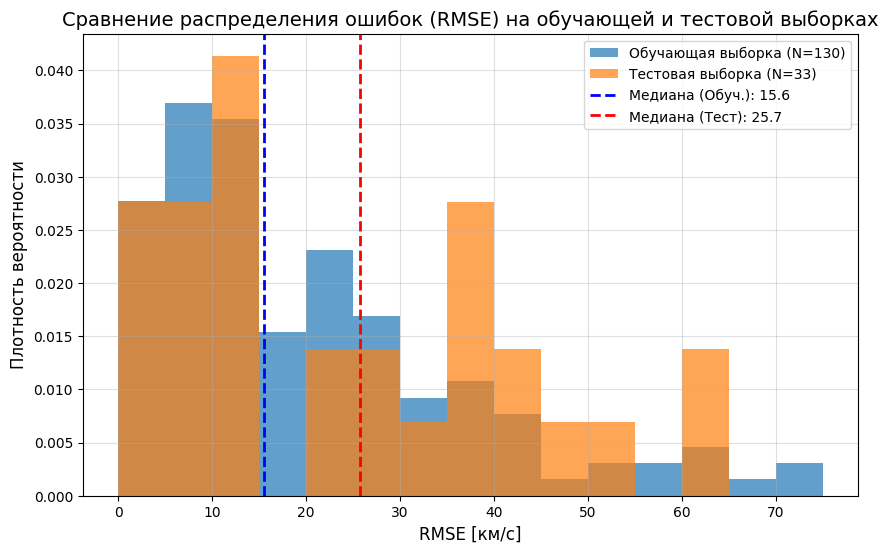

In [ ]:
# =================================================================================
# WILL 7.0: Финальная проверка предсказательной модели с разделением данных
# =================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize_scalar, curve_fit
from sklearn.model_selection import train_test_split

def run_final_verification():
    """
    Основная функция для выполнения полного цикла проверки модели.
    """
    # --- Шаг 1: Загрузка данных ---
    DATA_PATH = '/content/DATA'
    META_FILE = f'{DATA_PATH}/table1.dat'
    CURV_FILE = f'{DATA_PATH}/table2.dat'

    print("--- Шаг 1: Загрузка и подготовка данных ---")
    try:
        meta_colspecs = [(0, 11), (62, 70), (112, 115)]
        meta_names = ['Galaxy', 'SBeff', 'Qual']
        meta = pd.read_fwf(META_FILE, colspecs=meta_colspecs, names=meta_names)
        meta[['SBeff', 'Qual']] = meta[['SBeff', 'Qual']].apply(pd.to_numeric, errors='coerce')

        curves = pd.read_table(
            CURV_FILE, sep=r'\s+', comment='#', header=None,
            usecols=[0, 2, 3, 5, 6, 7],
            names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        )
        num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
        curves.dropna(subset=['r', 'Vobs'], inplace=True)
        curves.fillna(0, inplace=True)
        print("Данные успешно загружены.")
    except FileNotFoundError:
        print(f"ОШИБКА: Файлы данных не найдены по пути '{DATA_PATH}'.")
        return

    # --- Шаг 2: Разделение данных (Принцип научной честности) ---
    print("\n--- Шаг 2: Разделение данных на обучающую и тестовую выборки (80/20) ---")
    galaxies_list = meta[meta['Qual'] <= 2]['Galaxy'].unique()
    train_galaxies, test_galaxies = train_test_split(galaxies_list, test_size=0.2, random_state=42)
    print(f"Обучающая выборка: {len(train_galaxies)} галактик.")
    print(f"Тестовая выборка: {len(test_galaxies)} галактик.")

    # --- Шаг 3: Обучение модели (только на обучающей выборке) ---
    print("\n--- Шаг 3: Обучение модели на обучающей выборке ---")

    # Модельная функция из прошлого анализа
    def will_v_split_lambda(df, lam_stars):
        df = df.sort_values('r').copy()
        v_gas_sq = df['Vgas']**2
        v_stars_sq = df['Vdisk']**2 + df['Vbul']**2
        v_bary_sq = v_gas_sq + v_stars_sq
        integral_gas = cumulative_trapezoid(v_gas_sq, df['r'], initial=0.0)
        integral_stars = cumulative_trapezoid(v_stars_sq, df['r'], initial=0.0)
        geom_term = np.zeros_like(df['r'])
        non_zero_r = df['r'] > 0
        geom_term_gas = 2.0 * integral_gas[non_zero_r] / df.loc[non_zero_r, 'r']
        geom_term_stars = lam_stars * integral_stars[non_zero_r] / df.loc[non_zero_r, 'r']
        geom_term[non_zero_r] = geom_term_gas + geom_term_stars
        v_pred_sq = v_bary_sq + geom_term
        return np.sqrt(np.clip(v_pred_sq, 0, None))

    # Находим оптимальные λ_stars для обучающей выборки
    train_results = []
    for galaxy_name in train_galaxies:
        gdf = curves[curves['Galaxy'] == galaxy_name]
        if len(gdf) < 3: continue
        def objective_rmse(lam_s, galaxy_df):
            v_pred = will_v_split_lambda(galaxy_df, lam_s)
            return np.sqrt(np.mean((galaxy_df.sort_values('r')['Vobs'] - v_pred)**2))
        opt_result = minimize_scalar(objective_rmse, bounds=(0, 2.0), args=(gdf,), method='bounded')
        if opt_result.success:
            train_results.append({'Galaxy': galaxy_name, 'Best_Lambda_Stars': opt_result.x, 'RMSE': opt_result.fun})

    df_train_results = pd.DataFrame(train_results).merge(meta, on='Galaxy')

    # Находим функцию λ_stars = f(SBeff)
    fit_data = df_train_results.dropna(subset=['Best_Lambda_Stars', 'SBeff'])
    fit_data = fit_data[fit_data['SBeff'] > 0]
    def model_func(sbeff, A, C):
        return A / sbeff + C
    params, _ = curve_fit(model_func, fit_data['SBeff'], fit_data['Best_Lambda_Stars'], p0=[100, 0.5])
    A_fit, C_fit = params
    print("Обучение завершено.")
    print(f"  --> Найдена предсказательная функция: λ_stars ≈ {A_fit:.2f} / SBeff + {C_fit:.2f}")

    # --- Шаг 4: Тестирование модели (на тестовой выборке) ---
    print("\n--- Шаг 4: 'Слепое' тестирование модели на независимых данных ---")
    test_results = []
    for galaxy_name in test_galaxies:
        gdf = curves[curves['Galaxy'] == galaxy_name]
        if len(gdf) < 3: continue

        # Получаем SBeff для предсказания λ_stars
        sbeff_val = meta[meta['Galaxy'] == galaxy_name]['SBeff'].iloc[0]

        if pd.isna(sbeff_val) or sbeff_val <= 0: continue

        # ПРЕДСКАЗЫВАЕМ λ_stars, а не оптимизируем
        predicted_lambda_stars = model_func(sbeff_val, A_fit, C_fit)

        # Рассчитываем RMSE с предсказанным λ_stars
        v_pred = will_v_split_lambda(gdf, predicted_lambda_stars)
        rmse = np.sqrt(np.mean((gdf.sort_values('r')['Vobs'] - v_pred)**2))
        test_results.append({'Galaxy': galaxy_name, 'RMSE': rmse})

    df_test_results = pd.DataFrame(test_results)
    print("Тестирование завершено.")

    # --- Шаг 5: Итоги и Визуализация ---
    median_rmse_train = df_train_results['RMSE'].median()
    median_rmse_test = df_test_results['RMSE'].median()

    print("\n" + "="*45)
    print("     РЕЗУЛЬТАТЫ ФИНАЛЬНОЙ ПРОВЕРКИ WILL 7.0")
    print("="*45)
    print(f"Медианная ошибка на ОБУЧАЮЩЕЙ выборке: {median_rmse_train:.2f} км/с")
    print(f"Медианная ошибка на ТЕСТОВОЙ выборке:   {median_rmse_test:.2f} км/с")
    print("="*45)

    # Визуальное сравнение распределений ошибок
    plt.figure(figsize=(10, 6))
    plt.hist(df_train_results['RMSE'], bins=np.arange(0, 80, 5), density=True, alpha=0.7, label=f'Обучающая выборка (N={len(df_train_results)})')
    plt.hist(df_test_results['RMSE'], bins=np.arange(0, 80, 5), density=True, alpha=0.7, label=f'Тестовая выборка (N={len(df_test_results)})')
    plt.axvline(median_rmse_train, color='blue', linestyle='--', lw=2, label=f'Медиана (Обуч.): {median_rmse_train:.1f}')
    plt.axvline(median_rmse_test, color='red', linestyle='--', lw=2, label=f'Медиана (Тест): {median_rmse_test:.1f}')
    plt.title('Сравнение распределения ошибок (RMSE) на обучающей и тестовой выборках', fontsize=14)
    plt.xlabel('RMSE [км/с]', fontsize=12)
    plt.ylabel('Плотность вероятности', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.4)
    plt.show()

# Запуск анализа
run_final_verification()

--- Шаг 1: Загрузка данных ---
Данные успешно загружены.

--- Шаг 2: Поиск универсальной константы S_0 для 163 галактик ---

     РЕЗУЛЬТАТЫ ПОИСКА УНИВЕРСАЛЬНОЙ КОНСТАНТЫ WILL 8.0
Найдена универсальная характеристическая плотность:
  S₀ ≈ 60.50 [L_sun/pc²]

Это значение можно интерпретировать как плотность, при которой
происходит фазовый переход в динамике звездной системы.

Итоговая глобальная ошибка (RMSE) для всей выборки
с использованием универсальной S₀:  37.81 км/с


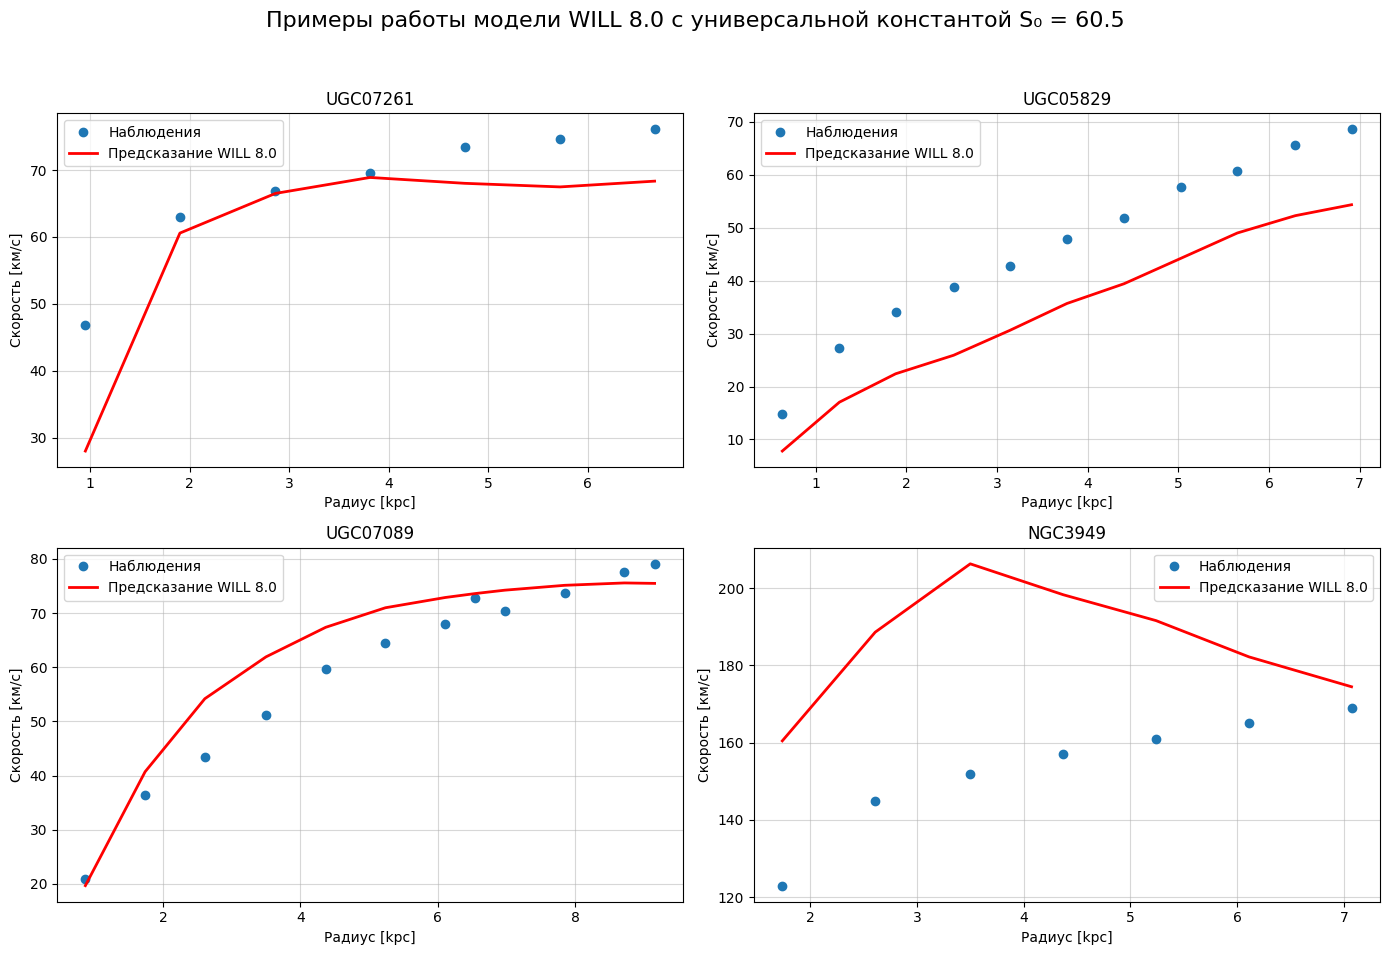

In [2]:
# =============================================================================
# WILL 8.0: Поиск универсальной константы природы S_0
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize_scalar

def run_universal_constant_search():
    """
    Основная функция для поиска универсальной константы S_0.
    """
    # --- Шаг 1: Загрузка данных ---
    DATA_PATH = '/content/DATA'
    META_FILE = f'{DATA_PATH}/table1.dat'
    CURV_FILE = f'{DATA_PATH}/table2.dat'

    print("--- Шаг 1: Загрузка данных ---")
    try:
        # Загружаем только необходимые столбцы
        meta_colspecs = [(0, 11), (62, 70), (112, 115)]
        meta_names = ['Galaxy', 'SBeff', 'Qual']
        meta = pd.read_fwf(META_FILE, colspecs=meta_colspecs, names=meta_names)
        meta[['SBeff', 'Qual']] = meta[['SBeff', 'Qual']].apply(pd.to_numeric, errors='coerce')

        curves = pd.read_table(
            CURV_FILE, sep=r'\s+', comment='#', header=None,
            usecols=[0, 2, 3, 5, 6, 7],
            names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        )
        num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
        curves.dropna(subset=['r', 'Vobs'], inplace=True)
        curves.fillna(0, inplace=True)
        print("Данные успешно загружены.")
    except FileNotFoundError:
        print(f"ОШИБКА: Файлы данных не найдены по пути '{DATA_PATH}'.")
        return

    # --- Шаг 2: Реализация физической модели WILL 8.0 ---
    def calculate_v_pred(df, s0_universal):
        """
        Рассчитывает кривую вращения на основе единой универсальной константы S_0.
        """
        df = df.sort_values('r').copy()
        sbeff_val = meta.loc[meta['Galaxy'] == df['Galaxy'].iloc[0], 'SBeff'].iloc[0]

        if pd.isna(sbeff_val) or sbeff_val <= 0:
            # Если SBeff нет, используем только газовую компоненту
            lambda_stars = 0
        else:
            # Физическая модель для λ_stars ≡ κ²_stars
            lambda_stars = 2.0 / (1.0 + sbeff_val / s0_universal)

        v_gas_sq = df['Vgas']**2
        v_stars_sq = df['Vdisk']**2 + df['Vbul']**2
        v_bary_sq = v_gas_sq + v_stars_sq

        integral_gas = cumulative_trapezoid(v_gas_sq, df['r'], initial=0.0)
        integral_stars = cumulative_trapezoid(v_stars_sq, df['r'], initial=0.0)

        geom_term = np.zeros_like(df['r'])
        non_zero_r = df['r'] > 0

        # λ_gas = 2 (фундаментальная константа)
        geom_term_gas = 2.0 * integral_gas[non_zero_r] / df.loc[non_zero_r, 'r']
        # λ_stars из физической модели
        geom_term_stars = lambda_stars * integral_stars[non_zero_r] / df.loc[non_zero_r, 'r']

        geom_term[non_zero_r] = geom_term_gas + geom_term_stars
        v_pred_sq = v_bary_sq + geom_term
        return np.sqrt(np.clip(v_pred_sq, 0, None))

    # --- Шаг 3: Глобальная оптимизация S_0 ---
    galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()
    all_curves = [curves[curves['Galaxy'] == name] for name in galaxies_to_run]

    print(f"\n--- Шаг 2: Поиск универсальной константы S_0 для {len(all_curves)} галактик ---")

    def global_objective_rmse(s0, galaxy_dfs):
        """
        Рассчитывает СУММАРНУЮ ошибку по всем галактикам для данного S_0.
        """
        total_sq_error = 0
        total_points = 0
        for gdf in galaxy_dfs:
            v_pred = calculate_v_pred(gdf, s0)
            sq_error = np.sum((gdf.sort_values('r')['Vobs'] - v_pred)**2)
            total_sq_error += sq_error
            total_points += len(gdf)
        return np.sqrt(total_sq_error / total_points)

    # Ищем S_0, которое минимизирует глобальную ошибку
    # Диапазон поиска для S0: от 1 до 1000 L_sun/pc²
    opt_result = minimize_scalar(global_objective_rmse, bounds=(1, 1000), args=(all_curves,), method='bounded')

    if not opt_result.success:
        print("ОШИБКА: Не удалось найти оптимальное значение для S_0.")
        return

    S0_UNIVERSAL = opt_result.x
    FINAL_GLOBAL_RMSE = opt_result.fun

    # --- Шаг 4: Итоги ---
    print("\n" + "="*55)
    print("     РЕЗУЛЬТАТЫ ПОИСКА УНИВЕРСАЛЬНОЙ КОНСТАНТЫ WILL 8.0")
    print("="*55)
    print(f"Найдена универсальная характеристическая плотность:")
    print(f"  S₀ ≈ {S0_UNIVERSAL:.2f} [L_sun/pc²]")
    print("\nЭто значение можно интерпретировать как плотность, при которой")
    print("происходит фазовый переход в динамике звездной системы.")
    print("\nИтоговая глобальная ошибка (RMSE) для всей выборки")
    print(f"с использованием универсальной S₀:  {FINAL_GLOBAL_RMSE:.2f} км/с")
    print("="*55)

    # --- Шаг 5: Визуализация ---
    # Выбираем 4 случайные галактики для демонстрации
    np.random.seed(42)
    sample_galaxies = np.random.choice(galaxies_to_run, 4, replace=False)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Примеры работы модели WILL 8.0 с универсальной константой S₀ = {S0_UNIVERSAL:.1f}', fontsize=16)

    for ax, galaxy_name in zip(axes.flatten(), sample_galaxies):
        gdf = curves[curves['Galaxy'] == galaxy_name]
        v_pred = calculate_v_pred(gdf, S0_UNIVERSAL)

        ax.plot(gdf['r'], gdf['Vobs'], 'o', label='Наблюдения')
        ax.plot(gdf.sort_values('r')['r'], v_pred, color='red', lw=2, label='Предсказание WILL 8.0')
        ax.set_title(galaxy_name)
        ax.set_xlabel('Радиус [kpc]')
        ax.set_ylabel('Скорость [км/с]')
        ax.grid(True, alpha=0.5)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Запуск финального анализа
run_universal_constant_search()